# NeuroGraphNet

*A graph-based deep learning framework for EEG seizure detection, designed to improve accuracy and interpretability by leveraging Graph Neural Networks (GNNs) to capture spatial and temporal brain dynamics.*

<hr />

This notebook presents **NeuroGraphNet**, a model that applies Graph Neural Networks to EEG data for seizure detection. The primary goal is to **compare the performance and interpretability of graph-based methods versus traditional deep learning approaches**. Through this comparison, we aim to demonstrate the advantages of incorporating brain connectivity information into the learning process.

**Authors**: Luca Di Bello, Guillaume André Bélissent, Abdessalem Ben Ali, Beatriz Izquierdo González

In [40]:
%load_ext autoreload
%autoreload 1
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from seiz_eeg.dataset import EEGDataset
from torch.utils.data import DataLoader
from src.utils.seeder import seed_everything

# set seaborn theme
sns.set_theme()

# create useful constants
RANDOM_SEED = 42
IS_SCITAS = False
DATA_ROOT = Path("/home/ogut/data") if IS_SCITAS else Path("./data")
CHECKPOINT_ROOT = Path("./.checkpoints")
SUBMISSION_ROOT = Path("./.submissions")

# create directories if they do not exist
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
SUBMISSION_ROOT.mkdir(parents=True, exist_ok=True)

# set dataset root
seed_everything(RANDOM_SEED)

# setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


## Dataset preprocessing

To preprocess the EEG data, we apply a series of time-domain filters to each segment using a strategy similar to the original `fft_filtering` function. This approach is chosen for its ability to effectively remove noise and artifacts while preserving the phase information of the underlying physiological signals, which is crucial for accurate seizure detection.

The filtering process involves two main steps:

1.  **Band-Pass Filtering**: A Butterworth [band-pass filter](https://en.wikipedia.org/wiki/Band-pass_filter) is applied.
    * **Low Cutoff (e.g., 0.5 Hz)**: This removes very slow DC drifts and baseline wander that are typically not of physiological interest and can obscure relevant EEG patterns.
    * **High Cutoff (e.g., 50 Hz)**: This attenuates high-frequency noise, including muscle artifacts (EMG) and other external interferences. The choice of 50 Hz (an update from a previous 30 Hz consideration) aims to retain a broader spectrum of brain activity, including the lower gamma band (30-50 Hz), which can contain important information for identifying seizure events, as suggested by related research and analysis.
    * The filter is applied using a zero-phase technique (like `sosfiltfilt`) to prevent any time distortion of the EEG waveforms.

2.  **Notch Filtering**: A [notch filter](https://en.wikipedia.org/wiki/Notch_filter) is applied to specifically remove power line interference (e.g., at 60 Hz, depending on the recording region). This type of interference is a common and strong artifact in EEG recordings, and its removal significantly cleans the signal.

This combined filtering strategy helps to suppress noise and eliminate irrelevant frequency components, thereby enhancing the signal-to-noise ratio. This allows the subsequent machine learning models to focus on the most informative neurophysiological patterns within the EEG signals. The filtered EEG segments are then typically loaded into memory as NumPy arrays using the `EEGDataset` class, with optional prefetching enabled to speed up data access during training.

Also, we split the `label` attribute into a pandas [MultiIndex](https://pandas.pydata.org/docs/user_guide/advanced.html) in order to easily query data. The original `label` index follows this format:

```plaintext
<patient_id>_<session_no>_<clip_no>_<segment_no>
```

In [41]:
%aimport src.utils.signal
from src.utils.signal import time_filtering, normalize
%aimport src.utils.dataset
from src.utils.dataset import ensure_eeg_multiindex

start = time.time()
print("⏳ Loading EEG segment tables…")
clips_tr = pd.read_parquet(DATA_ROOT / "train" / "segments.parquet").dropna()
clips_te = pd.read_parquet(DATA_ROOT / "test" / "segments.parquet").dropna()

# load clips with label
clips_tr = ensure_eeg_multiindex(clips_tr, id_col_name='id')
clips_te = ensure_eeg_multiindex(clips_te, id_col_name='id')

print(f"✔️ Loaded: {len(clips_tr)} train rows, {len(clips_te)} test rows "
      f"(took {time.time()-start:.1f}s)")
# NOTE: Merge clips for sanity checks
clips = pd.concat([clips_tr, clips_te]).reset_index()

⏳ Loading EEG segment tables…
✔️ Loaded: 12993 train rows, 3614 test rows (took 0.0s)


In [42]:
from src.utils.dataset import GraphEEGDataset

# Initialization for the training dataset
dataset_tr = GraphEEGDataset(
    root=str(DATA_ROOT / 'graph_dataset_train'),
    clips_df=clips_tr,
    signal_folder=str(DATA_ROOT / 'train'),
    extracted_features=None,
    use_extracted_features=False,
    edge_strategy='spatial',
    spatial_distance_file=str(DATA_ROOT / 'distances_3d.csv'),
    force_reprocess=True,
    prefetch_data=False,
)

# Initialization for the test dataset
dataset_te = GraphEEGDataset(
    root=str(DATA_ROOT / 'graph_dataset_test'),
    clips_df=clips_te,
    signal_folder=str(DATA_ROOT / 'test'),
    extracted_features=None,
    use_extracted_features=False,
    edge_strategy='spatial',
    spatial_distance_file=str(DATA_ROOT / 'distances_3d.csv'),
    force_reprocess=True, # Force reprocess for test dataset
    prefetch_data=False,
)

print(f"Training dataset object created: {dataset_tr}")
print(f"Test dataset object created: {dataset_te}")

# You can then check their lengths or get items:
print(f"Length of training dataset: {len(dataset_tr)}")
if len(dataset_tr) > 0:
    sample_train_data = dataset_tr[0]
    print(f"First training sample: {sample_train_data}")

# print(f"Length of test dataset: {len(dataset_te)}")
if len(dataset_te) > 0:
    sample_test_data = dataset_te[0]
    print(f"First test sample: {sample_test_data}, Label (y): {sample_test_data.y}")

🚀 Initializing GraphEEGDataset at root: data/graph_dataset_train
   - Mode: Processing raw signals
   - Edge strategy: spatial
   - Preprocessing: Filtering=True, Rereferencing=True, Normalization=True
   - Detected sampling rate: 250 Hz
   - Clip duration: 12.0s, Segment length: 3000 timesteps
   - Designing filters: Bandpass (0.5, 50.0) Hz, Notch 60.0 Hz
   - Loading spatial distances...
     - Loaded 180 unique spatial distances.
   - Calling PyG Dataset super().__init__()...
⚙️ download() called. Ensuring raw directory exists: data/graph_dataset_train/raw
   - Raw data is expected to be in/accessible via: data/train
   - PyG raw_dir is: data/graph_dataset_train/raw. Ensure data is available for process().
   - PyG Dataset super().__init__() call complete.
🏁 GraphEEGDataset initialization complete. Found 12993 items.
🚀 Initializing GraphEEGDataset at root: data/graph_dataset_test
   - Mode: Processing raw signals
   - Edge strategy: spatial
   - Preprocessing: Filtering=True, Rerefe

## Dataset structure

In this section the general dataset structure will be analyzed in order to (1) provide the reader some useful insights about the data we are working with (2) find some characteristics that allow us to distinguish between seizure and non-seizure people

Useful resources: 
- <https://seizure-eeg.readthedocs.io/en/latest/seiz_eeg/clips.html>
- <https://seizure-eeg.readthedocs.io/en/latest/seiz_eeg/dataset.html#seiz_eeg.dataset.EEGDataset>
- <https://seizure-eeg.readthedocs.io/en/latest/tutorials/1-events_and_dataframes.html> <-- most important

#### General information

In [43]:
dataset_tr.clips_df.columns

Index(['label', 'start_time', 'end_time', 'date', 'sampling_rate',
       'signals_path'],
      dtype='object')

In [44]:
# Set useful variables
clip_duration = dataset_tr.clip_duration  # 12 seconds
segment_time_points = clip_duration * dataset_tr.sampling_rate  # 12 s * 250 Hz = 3000 time points

#### Summary statistics

In [45]:
total_rows = dataset_tr.clips_df.shape[0]
total_patients = dataset_tr.clips_df.index.get_level_values("patient").nunique()
total_sessions = dataset_tr.clips_df.index.get_level_values("segment").nunique()
total_segments = dataset_tr.clips_df.index.get_level_values("segment").nunique()
total_missing_label = dataset_tr.clips_df["label"].isna().sum()

print(f"- Total rows: {total_rows}")
print(f"- Total patients: {total_patients}")
print(f"- Total sessions: {total_sessions}")
print(f"- Total segments: {total_segments}")
print(f"- Total missing labels: {total_missing_label}")

- Total rows: 12993
- Total patients: 97
- Total sessions: 285
- Total segments: 285
- Total missing labels: 0


In [46]:
# Calculate average sessions per patient
# Group by patient, count unique sessions within each patient, then average
avg_sessions_per_patient = dataset_tr.clips_df.groupby(level='patient').apply(lambda x: x.index.get_level_values('segment').nunique()).mean()

# Calculate average segments per session
# Group by unique session (patient, segment), count segments (rows) in each group, then average
avg_segments_per_session = dataset_tr.clips_df.groupby(level=['patient', 'segment']).size().mean()

# Calculate average segments per patient
# Group by patient, count segments (rows) for each patient, then average
avg_segments_per_patient = dataset_tr.clips_df.groupby(level="patient").size().mean()

print(f"- Avg. sessions per patient: {avg_sessions_per_patient}")
print(f"- Avg. segments per session: {avg_segments_per_session}")
print(f"- Avg. segments per patient: {avg_segments_per_patient}")

- Avg. sessions per patient: 95.81443298969072
- Avg. segments per session: 1.3979987088444157
- Avg. segments per patient: 133.94845360824743


In [47]:
# Compute some patient information to understand better the data
label_patients = dataset_tr.clips_df.groupby(level="patient")["label"]
total_no_seizures = (label_patients.max() == 0).sum()
min_seizures_per_session = label_patients.max().max()
max_seizures_per_session = label_patients.min().min()
avg_seizures_per_patients = label_patients.sum().mean()

print("\n[Patient information]")
print(f"- Total patients without seizures: {total_no_seizures}")
print(f"- Max. seizures per patient sessions: {max_seizures_per_session}")
print(f"- Min. seizures per patient sessions: {min_seizures_per_session}")
print(f"- Avg. seizures per patient: {avg_seizures_per_patients}")


[Patient information]
- Total patients without seizures: 1
- Max. seizures per patient sessions: 0
- Min. seizures per patient sessions: 1
- Avg. seizures per patient: 25.948453608247423


#### Sensors

In [48]:
print(f"- Total channels: {len(dataset_tr.channels)}")
print(f"- Channel names: {dataset_tr.channels}")

- Total channels: 19
- Channel names: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


**Sensor placement map**:

<img src="./assets/sensor_map.png" style="max-height: 500px;" />

In [49]:
distances = pd.read_csv(DATA_ROOT / 'distances_3d.csv')
distances.head()

,from,to,distance
0,FP1,FP1,0.000000
1,FP1,FP2,0.618000
2,FP1,F3,0.618969
3,FP1,F4,1.030322
4,FP1,C3,1.250226


#### Clip structure

In [50]:
example_sample = pd.read_parquet(DATA_ROOT / "train" / clips_tr.iloc[0]["signals_path"])
example_sample.head()

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,FZ,CZ,PZ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory data analysis

NOTE: the exploratory data analysis is performed only on training segments! 

### Label distribution

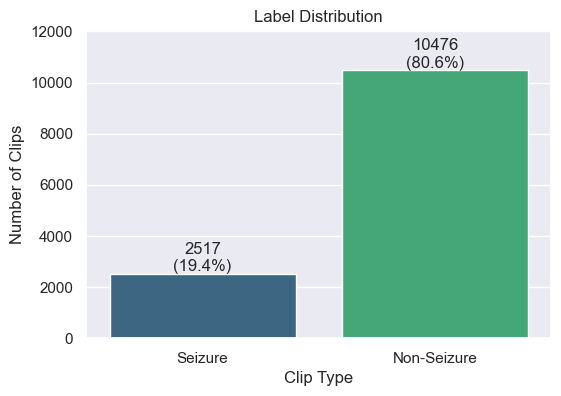

In [51]:
# Create a DataFrame for the label distribution plot
label_df = pd.DataFrame({'label': dataset_tr.labels})
label_df['Clip Type'] = label_df['label'].map({0: 'Non-Seizure', 1: 'Seizure'})

# Plot the label distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=label_df, x='Clip Type', palette='viridis', hue='Clip Type', dodge=False)
plt.title('Label Distribution')
plt.xlabel('Clip Type')
plt.ylabel('Number of Clips')

# Add counts and percentages on top of bars
total_count = len(label_df)
for container in ax.containers:
    labels = [f'{int(v)}\n({(100 * v / total_count):.1f}%)' for v in container.datavalues]
    ax.bar_label(container, labels=labels)

plt.ylim(0, label_df['Clip Type'].value_counts().max() * 1.15) # Adjust y-limit for text
plt.show()

There is a significant class imbalance, with seizure segments being much less frequent than non-seizure segments (~2500 records vs ~10500 records). To address this challenge, the following techniques can be employed:

- Use data splitting strategies that preserve the original class distribution (stratified splitting)
- Implementing oversampling methods to increase the representation of the minority class (seizure segments)

### Patients vs sessions vs segments: understanding magnitude of the data

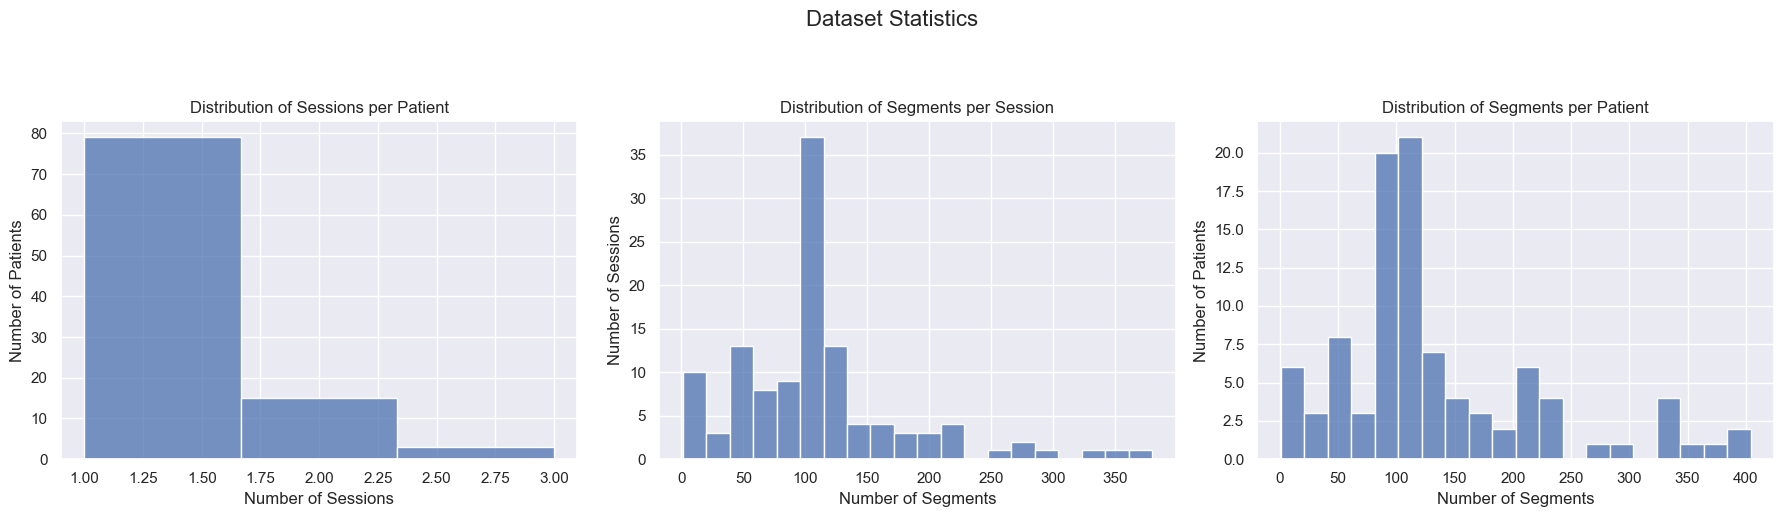

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Dataset Statistics', fontsize=16, y=1.03) # Add a main title

# 1. Distribution of Number of Sessions per Patient
try:
    # for each patient, how many unique values exist for each of the other index levels/columns
    patient_sessions_df = dataset_tr.clips_df.groupby(level="patient").nunique()
    num_sessions_per_patient = dataset_tr.clips_df.reset_index().groupby('patient')['session'].nunique()
    sns.histplot(data=num_sessions_per_patient, ax=axes[0], kde=False, bins=max(1, num_sessions_per_patient.max()))
    axes[0].set_title('Distribution of Sessions per Patient')
    axes[0].set_xlabel('Number of Sessions')
    axes[0].set_ylabel('Number of Patients')
except Exception as e:
    axes[0].set_title('Error: Sessions per Patient')
    axes[0].text(0.5, 0.5, f"Could not plot:\n{e}", ha='center', va='center', wrap=True)
    print(f"Error plotting 'Sessions per Patient': {e}")


# 2. Distribution of segments per session
try:
    segments_per_session = dataset_tr.clips_df.groupby(level=['patient', 'session']).size()
    sns.histplot(data=segments_per_session, ax=axes[1], kde=False, bins=20) # Adjust bins as needed
    axes[1].set_title('Distribution of Segments per Session')
    axes[1].set_xlabel('Number of Segments')
    axes[1].set_ylabel('Number of Sessions')
except Exception as e:
    axes[1].set_title('Error: Segments per Session')
    axes[1].text(0.5, 0.5, f"Could not plot:\n{e}", ha='center', va='center', wrap=True)
    print(f"Error plotting 'Segments per Session': {e}")


# 3. Distribution of Segments per patient
try:
    segments_per_patient = dataset_tr.clips_df.groupby(level='patient').size()
    sns.histplot(data=segments_per_patient, ax=axes[2], kde=False, bins=20)
    axes[2].set_title('Distribution of Segments per Patient')
    axes[2].set_xlabel('Number of Segments')
    axes[2].set_ylabel('Number of Patients')
except Exception as e:
    axes[2].set_title('Error: Segments per Patient')
    axes[2].text(0.5, 0.5, f"Could not plot:\n{e}", ha='center', va='center', wrap=True)
    print(f"Error plotting 'Segments per Patient': {e}")


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Patients vs seizures: understanding distribution of samples

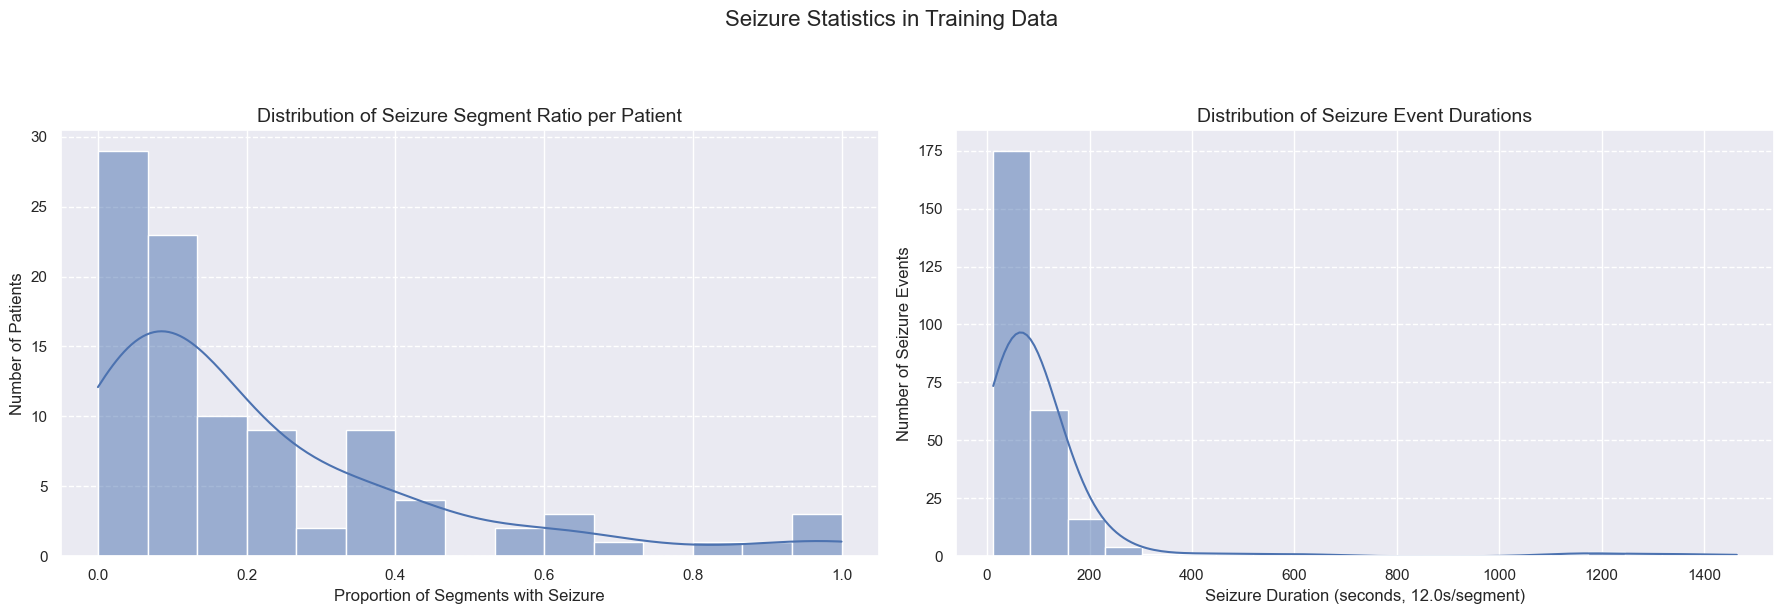

In [53]:
%aimport src.utils.stats
from src.utils.stats import calculate_seizure_event_durations

fig, axes = plt.subplots(1, 2, figsize=(18, 6)) # Adjusted figsize slightly for better aspect
fig.suptitle('Seizure Statistics in Training Data', fontsize=16, y=1.02)

# 1. Seizure ratio per patient
try:
    seizure_ratio_per_patient = dataset_tr.clips_df.groupby("patient")["label"].mean()
    sns.histplot(seizure_ratio_per_patient, ax=axes[0], kde=True, bins=15)
    axes[0].set_title("Distribution of Seizure Segment Ratio per Patient", fontsize=14)
    axes[0].set_xlabel("Proportion of Segments with Seizure", fontsize=12)
    axes[0].set_ylabel("Number of Patients", fontsize=12)
    axes[0].grid(axis='y', linestyle='--')
except Exception as e:
    axes[0].set_title("Seizure Ratio per Patient", fontsize=14)
    axes[0].text(0.5, 0.5, f"Could not plot:\n{e}", ha='center', va='center', wrap=True)
    print(f"Error during seizure ratio plot: {e}")

# 2. Seizure event durations (Plot index was 1, matching original request for 2 plots)
try:
    # Calculate durations using the optimized function
    # This assumes dataset_tr.clips_df is sorted chronologically for consecutive segment checks
    seizure_durations_in_seconds = calculate_seizure_event_durations(
        dataset_tr.clips_df, 
        segment_duration_seconds=clip_duration
    )
    sns.histplot(seizure_durations_in_seconds, ax=axes[1], kde=True, bins=20)
    axes[1].set_title("Distribution of Seizure Event Durations", fontsize=14)
    axes[1].set_xlabel(f"Seizure Duration (seconds, {clip_duration}s/segment)", fontsize=12)
    axes[1].set_ylabel("Number of Seizure Events", fontsize=12)
    axes[1].grid(axis='y', linestyle='--')
except Exception as e:
    axes[1].set_title("Seizure Event Durations", fontsize=14)
    axes[1].text(0.5, 0.5, f"Could not plot:\n{e}", ha='center', va='center', wrap=True)
    print(f"Error during seizure duration plot: {e}")


plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for suptitle
plt.show()

### Seizure vs Non-Seizure Clips after filtering: per-channel signal overview

In [54]:
%aimport src.utils.plot
from src.utils.plot import plot_eeg_clip, plot_signals

MAX_ITERATION_LIMIT=10_000
seizure_example = None
non_seizure_example = None

# skip first entry
for i, clip in enumerate(dataset_tr[1:]):
    # get the EEG clip and its label
    x, y = clip.x, clip.y  # Unpack the clip
    if y == 1 and seizure_example is None:
        print("index",i,"seizure")
        seizure_example = (x,i)
    elif y == 0 and non_seizure_example is None:
        print("index",i,"non-seizure")
        non_seizure_example = (x,i)

    # Stop if both examples are found
    if seizure_example is not None and non_seizure_example is not None:
        break
    # add limit to search
    if i > MAX_ITERATION_LIMIT: 
        print("Warning: Reached iteration limit before finding both example types.")
        break

index 0 seizure
index 99 non-seizure


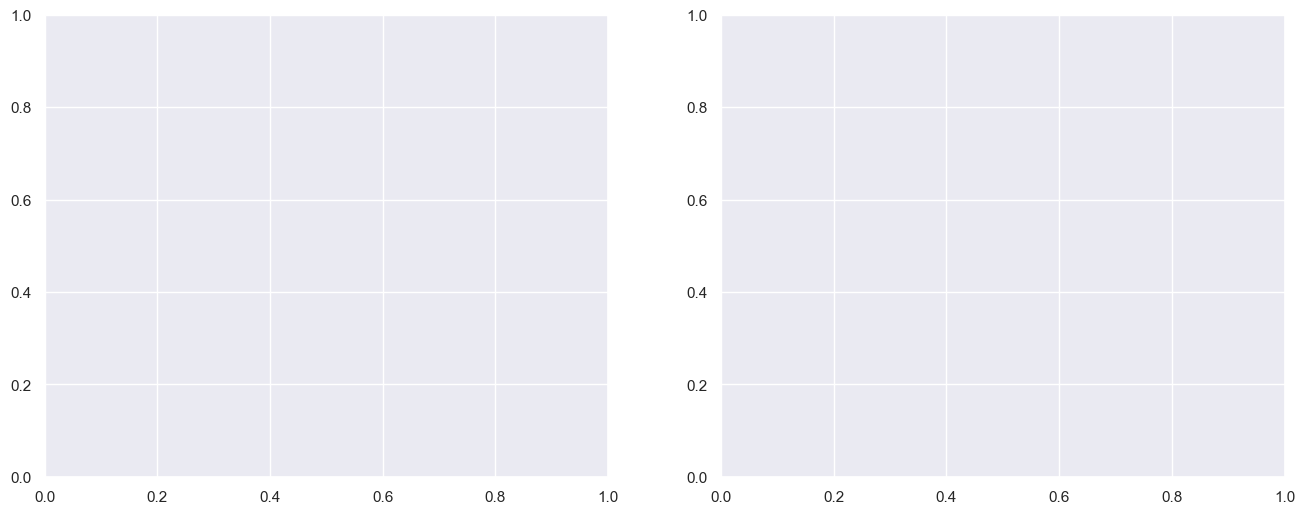

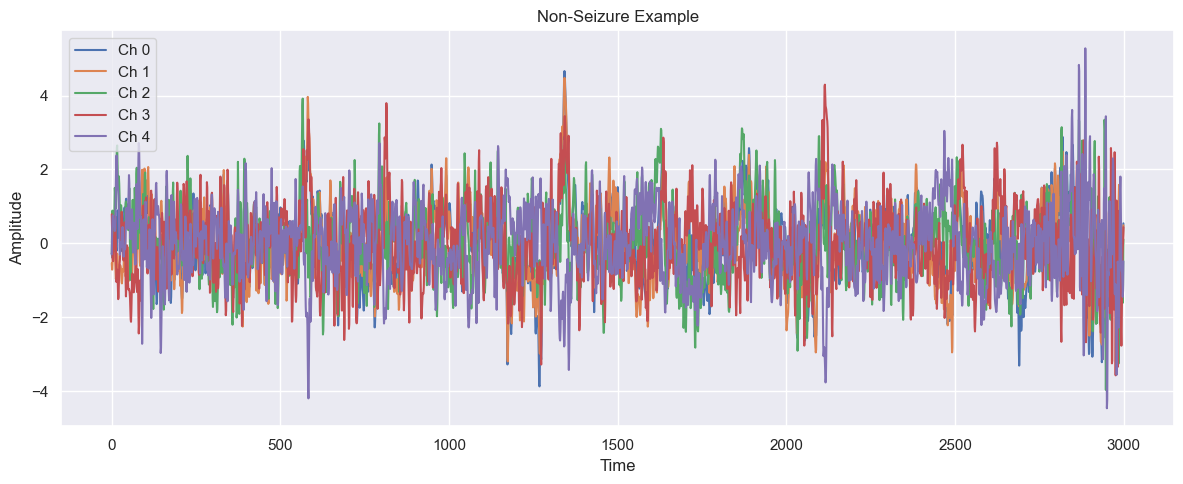

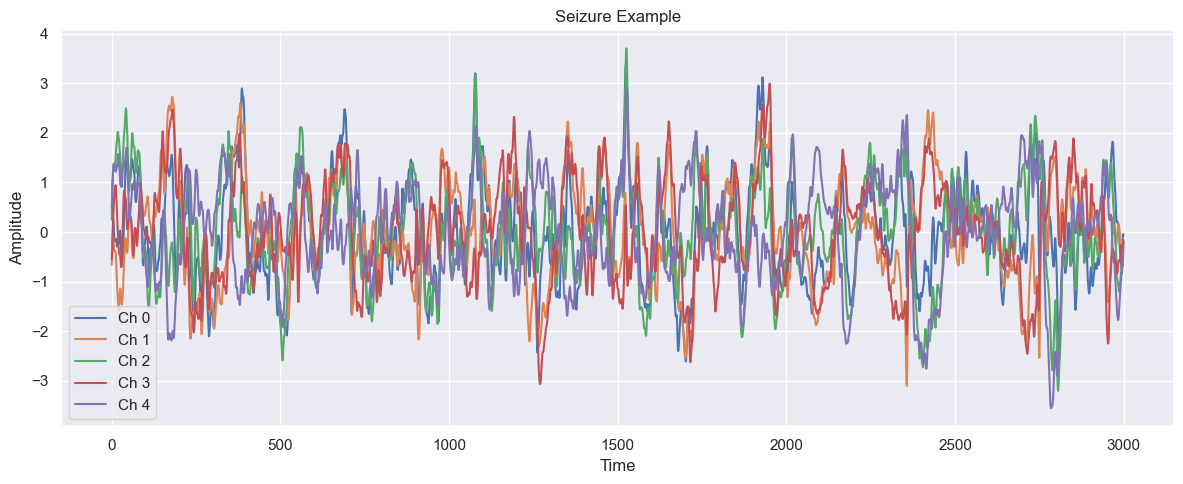

<Figure size 640x480 with 0 Axes>

In [55]:
# Plot non-seizure example on the first subplot (axes[0])
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Adjusted figsize for better aspect ratio

if non_seizure_example is not None:
    plot_signals(non_seizure_example[0], "Non-Seizure Example")
    plot_eeg_clip(non_seizure_example[0], "Non-Seizure Example", 
                    dataset_tr.sampling_rate, dataset_tr.channels, offset_factor=10, ax=axes[0])
else:
    print("\n❌ Could not find a non-seizure example clip to plot.")
    axes[0].text(0.5, 0.5, "Non-seizure example not found", ha='center', va='center', fontsize=12)
    axes[0].set_title("Non-Seizure Example")

# Plot seizure example on the second subplot (axes[1])
if seizure_example is not None:
    plot_signals(seizure_example[0], "Seizure Example")
    plot_eeg_clip(seizure_example[0], "Seizure Example", 
                    dataset_tr.sampling_rate, dataset_tr.channels, offset_factor=10, ax=axes[1])
else:
    print("\n❌ Could not find a seizure example clip to plot.")
    axes[1].text(0.5, 0.5, "Seizure example not found", ha='center', va='center', fontsize=12)
    axes[1].set_title("Seizure Example")

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

### Understanding how each filter affects the raw signal

In [56]:
clips_tr

label  start_time  end_time       date  \
patient  session clip segment                                           
pqejgcff 1       0    0            1         0.0      12.0 2003-01-01   
                      1            1        12.0      24.0 2003-01-01   
                      2            1        24.0      36.0 2003-01-01   
                      3            1        36.0      48.0 2003-01-01   
                      4            1        48.0      60.0 2003-01-01   
...                              ...         ...       ...        ...   
pqejgvqb 1       13   8            1        96.0     108.0 2015-01-01   
                      9            1       108.0     120.0 2015-01-01   
                      10           1       120.0     132.0 2015-01-01   
                      11           1       132.0     144.0 2015-01-01   
                      12           0       144.0     156.0 2015-01-01   

                               sampling_rate  \
patient  session clip segment                  
pqejgcff 1       0    0                  250   
                      1                  250   
                      2                  250   
                      3                  250   
                      4                  250   
...                                      ...   
pqejgvqb 1       13   8                  250   
                      9                  250   
                      10                 250   
                      11                 250   
                      12                 250   

                                                     signals_path  
patient  session clip segment                                      
pqejgcff 1       0    0        signals/pqejgcff_s001_t000.parquet  
                      1        signals/pqejgcff_s001_t000.parquet  
                      2        signals/pqejgcff_s001_t000.parquet  
                      3        signals/pqejgcff_s001_t000.parquet  
                      4        signals/pqejgcff_s001_t000.parquet  
...                                                           ...  
pqejgvqb 1       13   8        signals/pqejgvqb_s001_t013.parquet  
                      9        signals/pqejgvqb_s001_t013.parquet  
                      10       signals/pqejgvqb_s001_t013.parquet  
                      11       signals/pqejgvqb_s001_t013.parquet  
                      12       signals/pqejgvqb_s001_t013.parquet  

[12993 rows x 6 columns]

In [57]:
%aimport src.utils.plot
from src.utils.plot import plot_signals

row_seizure = clips_tr.iloc[seizure_example[1]]
row_non_seizure = clips_tr.iloc[non_seizure_example[1]]

# signal = pd.read_parquet(DATA_ROOT / "train" / row_seizure["signals_path"])
seizure_signal = pd.read_parquet(DATA_ROOT / "train" / row_seizure["signals_path"]).values.T
non_seizure_signal = pd.read_parquet(DATA_ROOT / "train" / row_non_seizure["signals_path"]).values.T

#### Option A - Raw signal

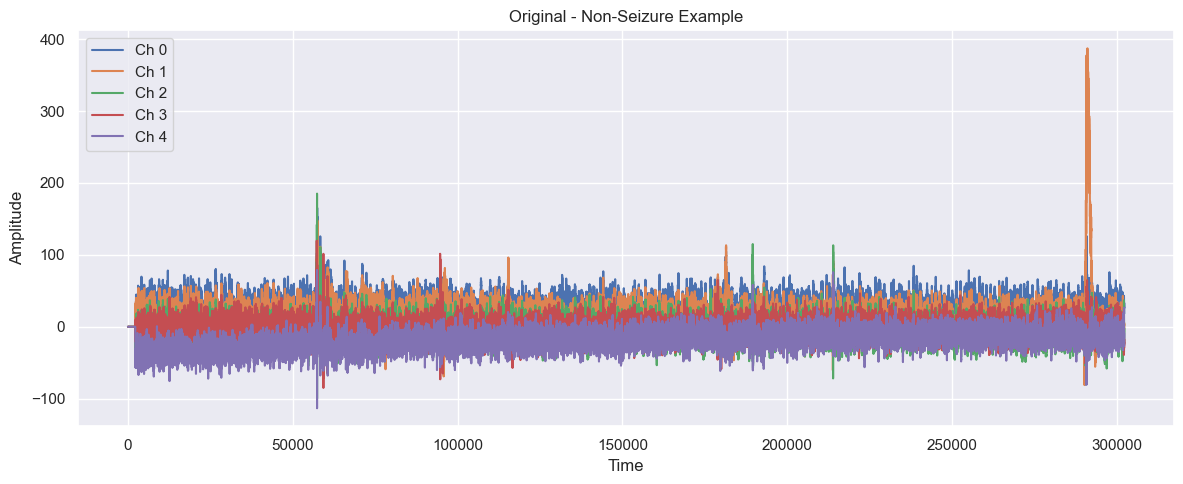

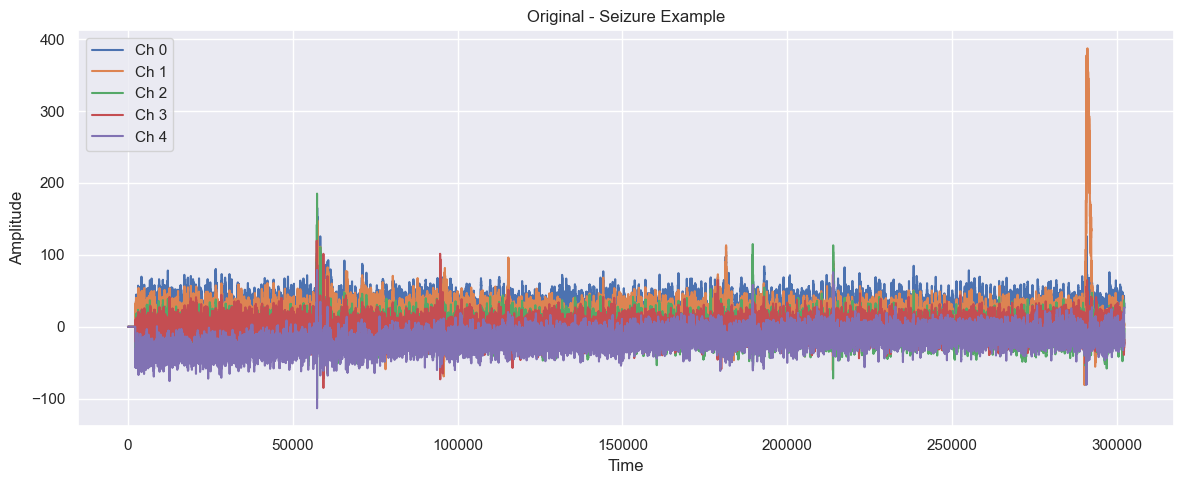

In [58]:
plot_signals(non_seizure_signal, "Original - Non-Seizure Example")
plot_signals(seizure_signal, "Original - Seizure Example")

#### Option B - Signal time filtering

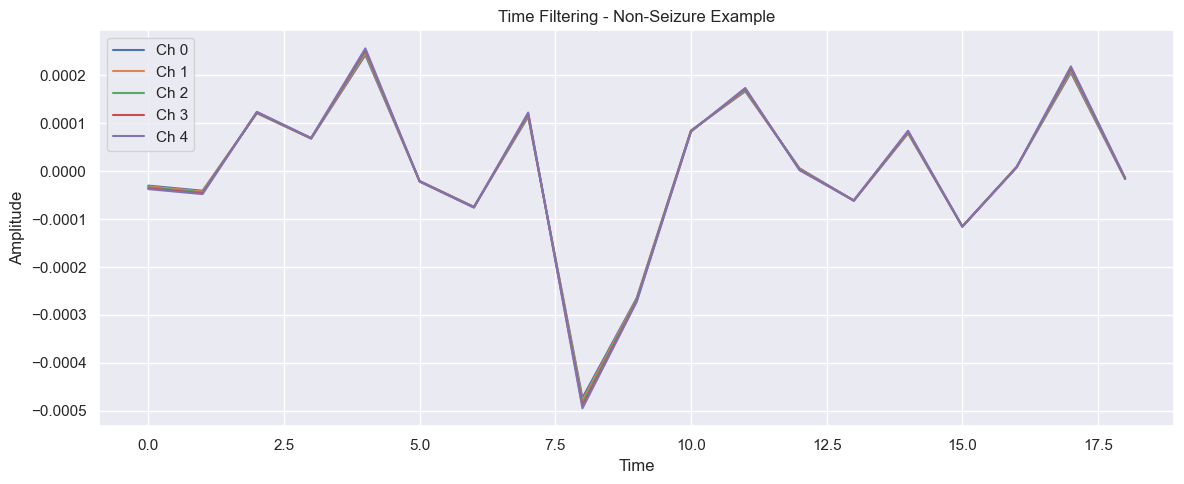

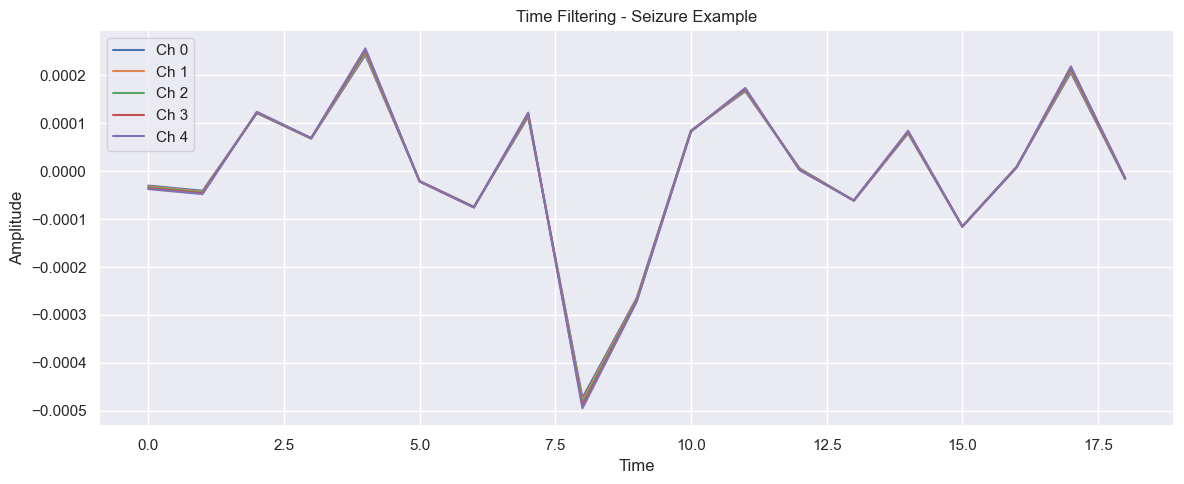

In [59]:
plot_signals(time_filtering(non_seizure_signal.T), "Time Filtering - Non-Seizure Example")
plot_signals(time_filtering(seizure_signal.T), "Time Filtering - Seizure Example")

#### Option B - Signal rereference 

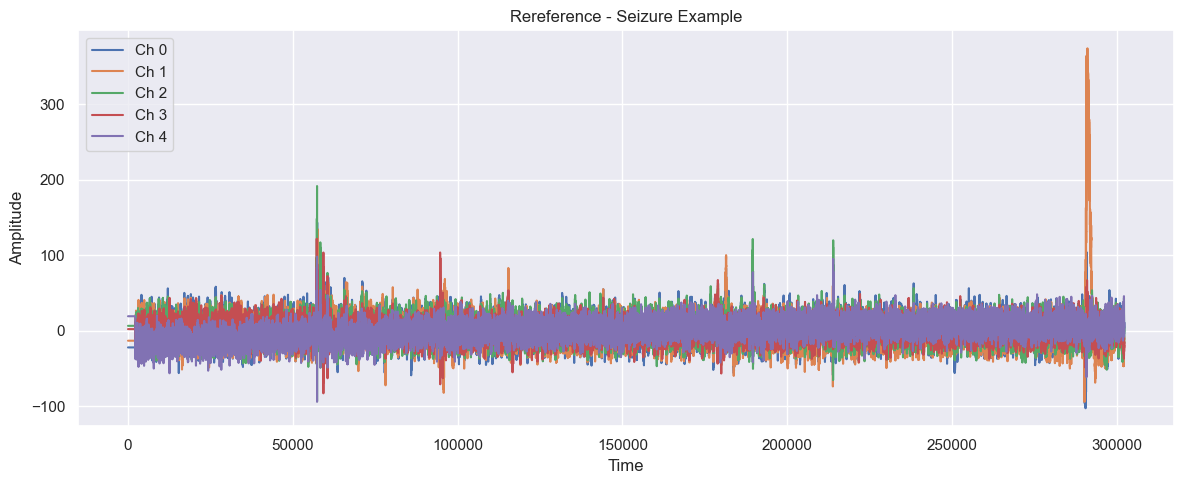

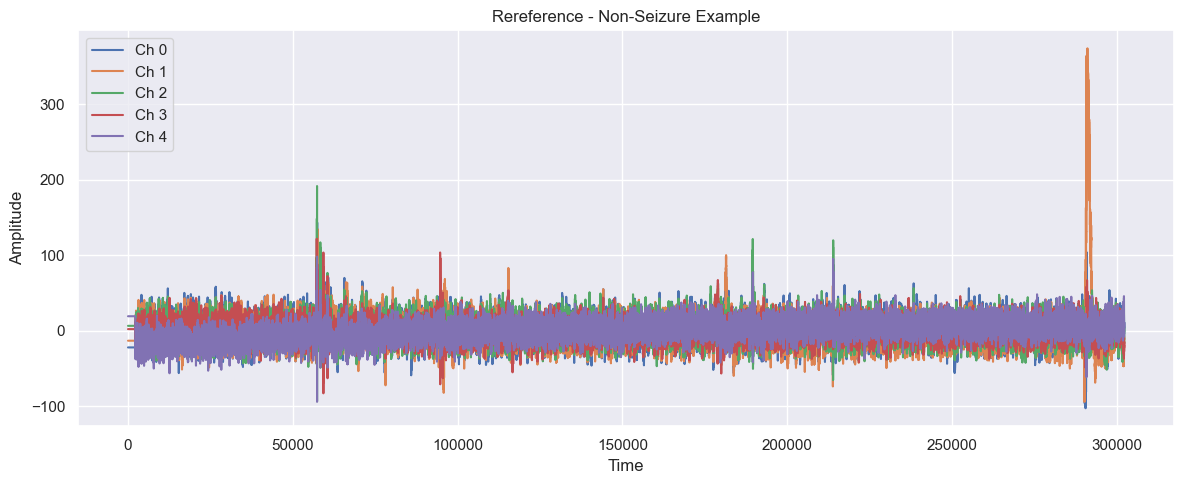

In [60]:
from src.utils.signal import rereference
plot_signals(rereference(seizure_signal), "Rereference - Seizure Example")
plot_signals(rereference(non_seizure_signal), "Rereference - Non-Seizure Example")

#### Option C - Signal normalization 

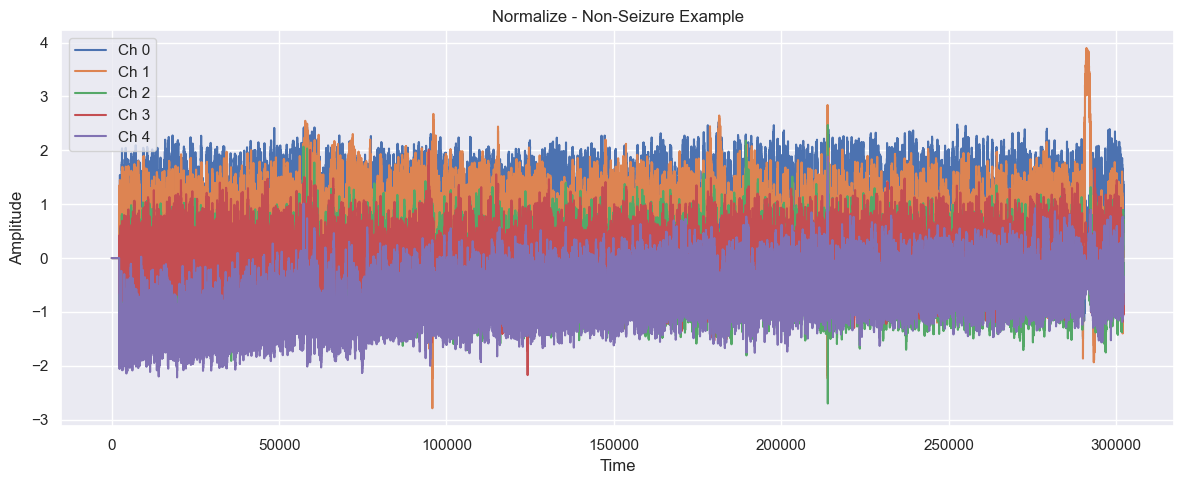

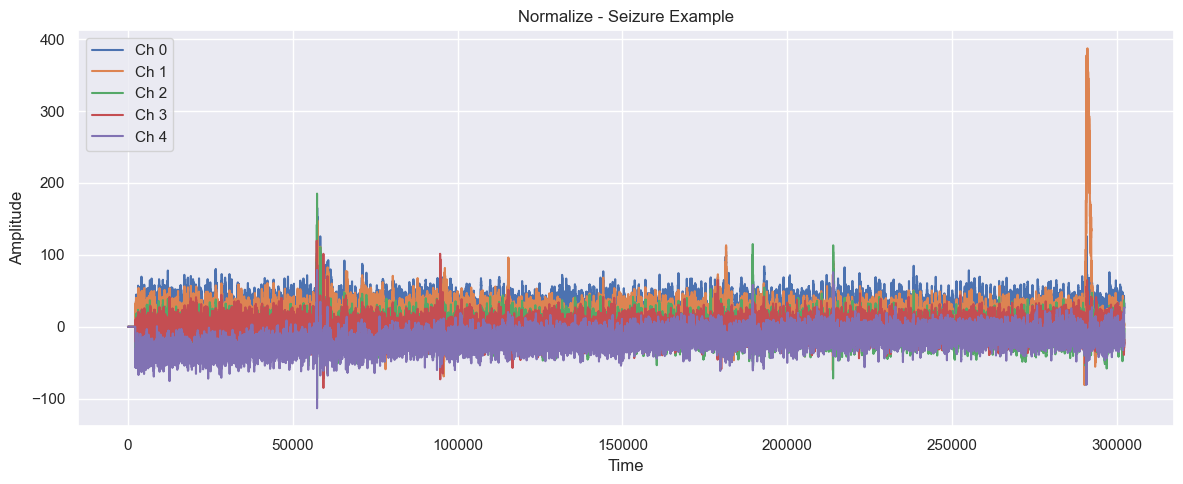

In [61]:
from src.utils.signal import normalize
plot_signals(normalize(non_seizure_signal), "Normalize - Non-Seizure Example")
plot_signals(seizure_signal, "Normalize - Seizure Example")

##### Option D: Normalize + Rereference

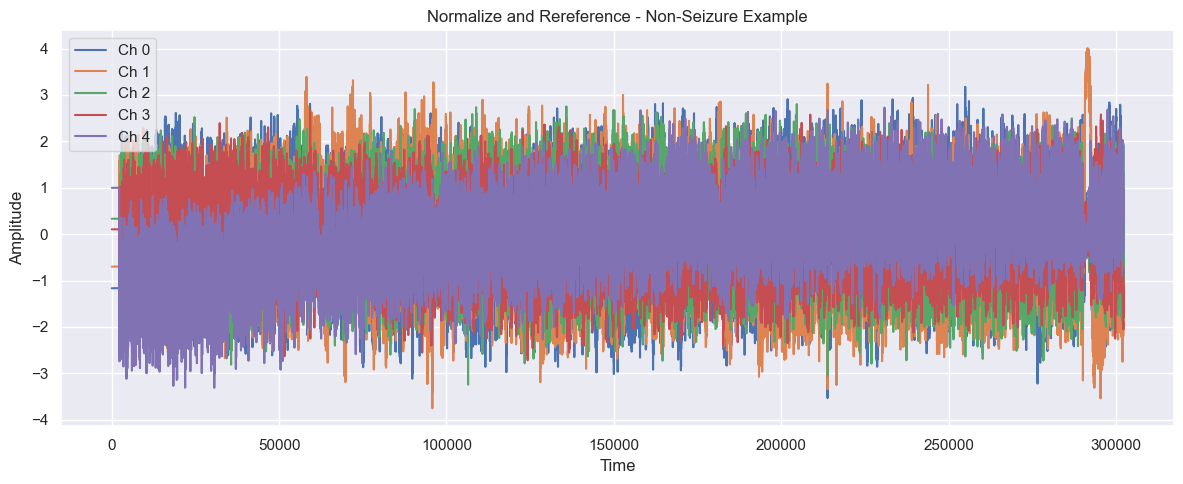

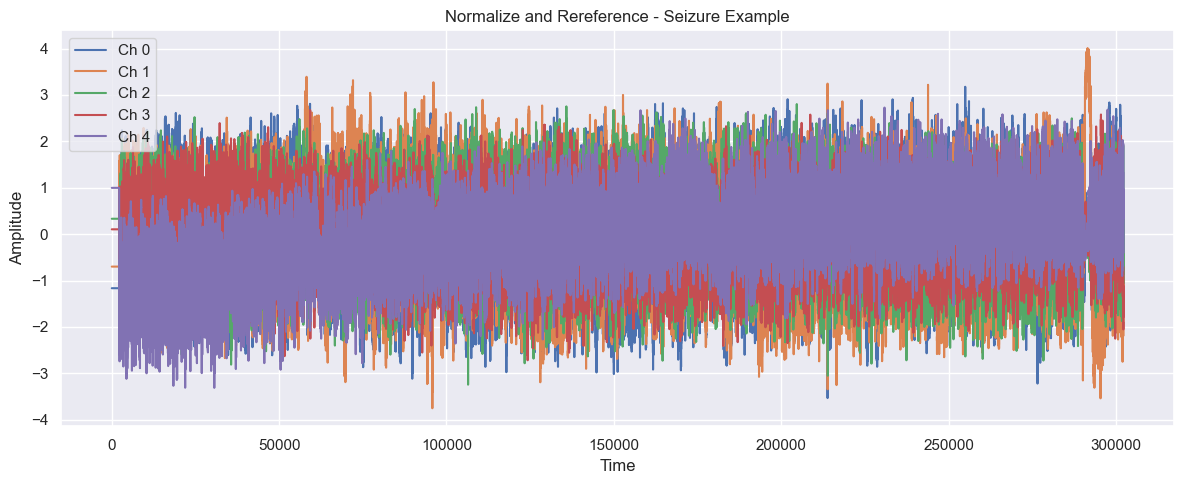

In [62]:
plot_signals(normalize(rereference(non_seizure_signal)), "Normalize and Rereference - Non-Seizure Example")
plot_signals(normalize(rereference(seizure_signal)), "Normalize and Rereference - Seizure Example")

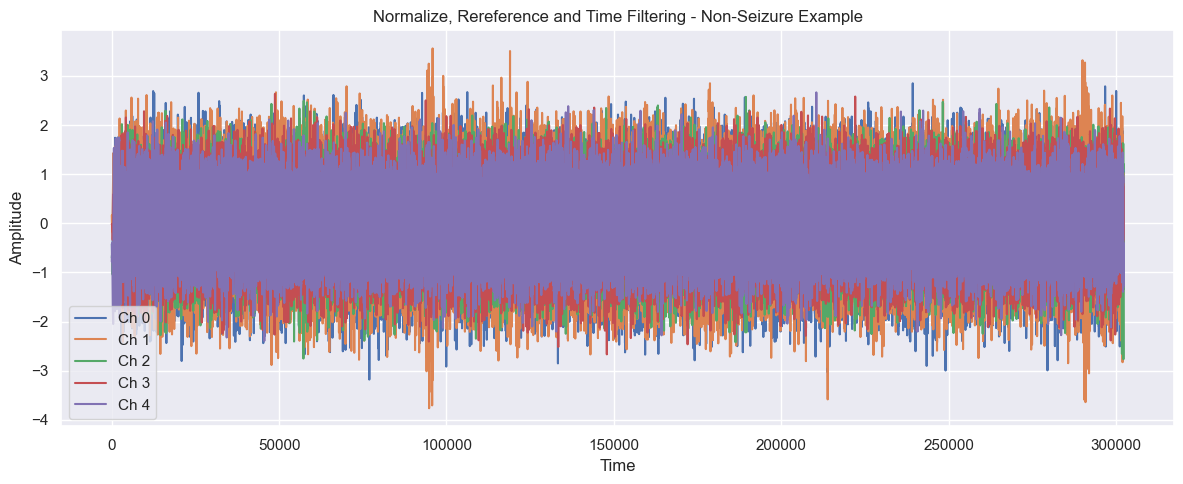

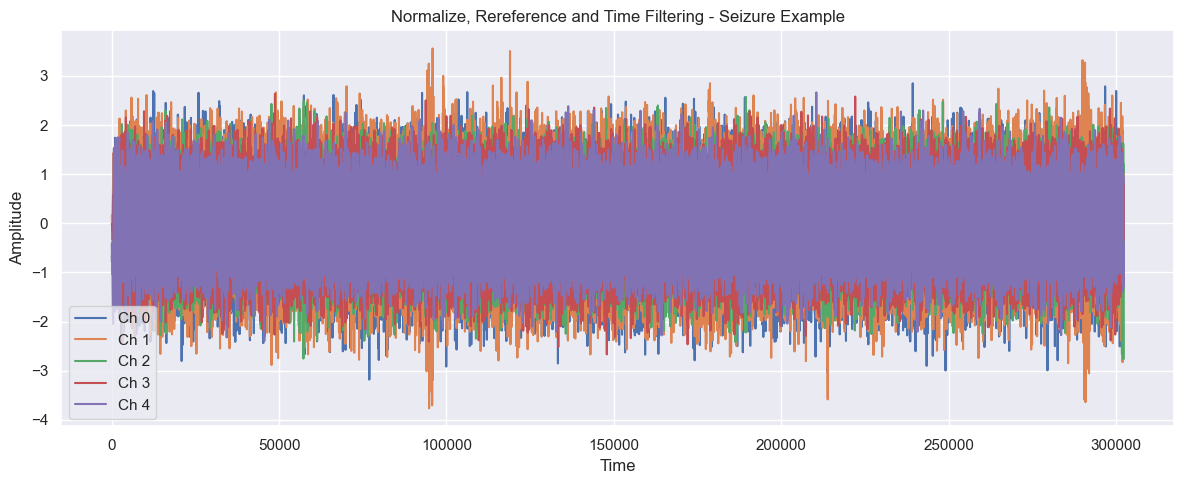

In [63]:
plot_signals(normalize(rereference(time_filtering(non_seizure_signal.T).T)), "Normalize, Rereference and Time Filtering - Non-Seizure Example")
plot_signals(normalize(rereference(time_filtering(seizure_signal.T).T)), "Normalize, Rereference and Time Filtering - Seizure Example")

### Seizure vs Non-Seizure Clips: Power Spectral Density

The [*Power Spectral Density* (PSD)](https://en.wikipedia.org/wiki/Spectral_density) describes how the power of a signal (like EEG, often treated as a stationary random process over short intervals) is distributed across different frequencies. It's suitable for ongoing signals where total energy might be infinite, but average power is finite.

The *Power Spectral Density*, $S_{xx}(f)$, is fundamentally related to the signal's autocorrelation function, $R_{xx}(\tau)$, via the [Wiener-Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem), which states that the PSD is the Fourier transform ($\mathcal{F}$) of the autocorrelation function:

$$
S_{xx}(f) = \mathcal{F}\{\mathbf{R}_{xx}(\tau)\}
$$

In practice, the PSD function $S_{xx}(f)$ can be estimated from finite signal segments using techniques like [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method), which averages modified periodograms from overlapping windowed portions of the signal.

Suggested resources:

- <https://ethz.ch/content/dam/ethz/special-interest/baug/ibk/structural-mechanics-dam/education/identmeth/2020/welch.pdf>
- <https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html>

⏳ Calculating PSD for up to 5000 clips...
   Processed 500/5000 items for PSD...
   Processed 1000/5000 items for PSD...
   Processed 1500/5000 items for PSD...
   Processed 2000/5000 items for PSD...
   Processed 2500/5000 items for PSD...
   Processed 3000/5000 items for PSD...
   Processed 3500/5000 items for PSD...
   Processed 4000/5000 items for PSD...
   Processed 4500/5000 items for PSD...
   Processed 5000/5000 items for PSD...
✔️ Reached calculation limit of 5000 clips for PSD.
✔️ Finished PSD calculation for 5000 items.


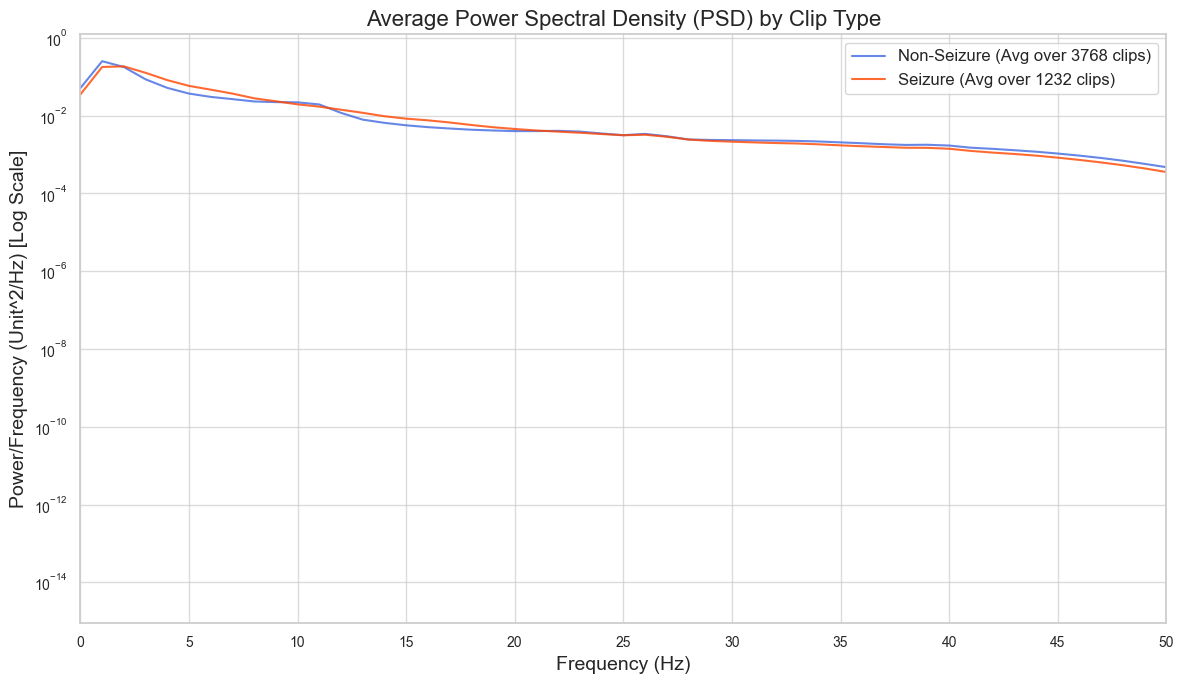


--- PSD Analysis Summary ---
PSD calculation complete for 1232 seizure and 3768 non-seizure clips (out of 5000 items iterated from dataset_tr).


In [ ]:
from scipy.signal import welch

psd_seizure_list = []
psd_non_seizure_list = []
count_seizure = 0
count_non_seizure = 0

limit = 1000
processed_count = 0
freqs_welch = None # To store frequency bins from Welch

print(f"⏳ Calculating PSD for up to {limit} clips...")
log_interval = max(1, limit // 10)

for i in range(len(dataset_tr)): # Iterate using index to easily get items
    if processed_count >= limit:
        print(f"✔️ Reached calculation limit of {limit} clips for PSD.")
        break
    
    try:
        data_obj = dataset_tr[i] # Get Data object
    except Exception as e:
        print(f"Warning: Error retrieving item {i} from dataset_tr: {e}. Skipping.")
        continue

    # Extract signal (x) and label (y)
    # x from GraphEEGDataset is (num_channels, num_timesteps) as a Tensor
    signal_data_ch_time = data_obj.x 
    label_tensor = data_obj.y

    if signal_data_ch_time is None:
        print(f"Warning: Skipping item {i} as signal_data_ch_time (clip.x) is None.")
        processed_count += 1 # Count as processed even if skipped here
        continue
        
    # Convert to NumPy array if it's a tensor
    if hasattr(signal_data_ch_time, 'numpy'):
        signal_data_ch_time = signal_data_ch_time.numpy()

    # Welch expects time as the first dimension for axis=0, or specify axis for (channels, time)
    # Current signal_data_ch_time is (num_channels, num_timesteps)
    # We need to transpose it to (num_timesteps, num_channels) for welch(..., axis=0)
    signal_data_time_ch = signal_data_ch_time.T # Now (num_timesteps, num_channels)

    actual_time_points, actual_num_channels = signal_data_time_ch.shape

    if actual_time_points < 2 or actual_num_channels == 0:
        print(f"Warning: Skipping item {i} due to invalid data shape after extraction {signal_data_time_ch.shape}")
        processed_count += 1
        continue

    # Determine label
    current_label = None
    if label_tensor is not None and pd.notna(label_tensor.item()): # Check for NaN if y can be NaN
        current_label = int(label_tensor.item())
    else: # Handle cases where label might be missing (e.g., for a test set, though less common for PSD analysis by class)
        print(f"Warning: Item {i} has no valid label. Skipping for class-based PSD.")
        processed_count += 1
        continue 
    # For this analysis, we need labels. If a clip has no label, we skip it.
    if current_label is None:
        processed_count += 1
        continue


    # --- Calculate PSD using Welch's method ---
    # nperseg: Length of each segment for Welch. Using 1-second windows.
    # dataset_tr.segment_length_timesteps might be the full clip length.
    # For Welch, nperseg is typically smaller than the total signal length to allow averaging.
    # Let's use 1-second segments for nperseg if signal is long enough.
    nperseg_welch = dataset_tr.sampling_rate # 1 second window
    if actual_time_points < nperseg_welch:
        nperseg_welch = actual_time_points # Use full length if shorter than 1s, ensure it's >=2
    
    if nperseg_welch < 2: # Welch requires nperseg >= 2
        # print(f"Warning: Skipping item {i} due to insufficient length ({actual_time_points}) for nperseg={nperseg_welch}.")
        processed_count += 1
        continue

    try:
        # Calculate PSD for each channel (axis=0 because signal_data_time_ch is (time, channels))
        f_bins, psd_channels_output = welch(signal_data_time_ch, fs=dataset_tr.sampling_rate, axis=0, nperseg=nperseg_welch)

        if freqs_welch is None: # Store frequencies from the first successful calculation
            freqs_welch = f_bins

        # Average PSD across channels for this clip
        psd_clip_avg = psd_channels_output.mean(axis=1) # psd_channels_output is (freq_bins, channels)

        if current_label == 1:
            psd_seizure_list.append(psd_clip_avg)
            count_seizure += 1
        elif current_label == 0: # Explicitly check for 0 for non-seizure
            psd_non_seizure_list.append(psd_clip_avg)
            count_non_seizure += 1
        # else: # Other label values, if any, are ignored for this binary comparison
            # pass

    except ValueError as e:
        print(f"Warning: Error calculating PSD for item {i}: {e}. Skipping.")
        pass # Skip if Welch calculation gives an error
    
    processed_count += 1
    if processed_count % log_interval == 0 or processed_count == limit:
        print(f"   Processed {processed_count}/{limit} items for PSD...")


print(f"✔️ Finished PSD calculation for {processed_count} items.")

# --- Compute average PSD for each class ---
avg_psd_seizure = np.mean(psd_seizure_list, axis=0) if count_seizure > 0 else None
avg_psd_non_seizure = np.mean(psd_non_seizure_list, axis=0) if count_non_seizure > 0 else None

# --- Plotting PSD ---
sns.set_theme(style="whitegrid") # Apply seaborn theme for consistency
if freqs_welch is not None:
    plt.figure(figsize=(12, 7)) # Adjusted size
    plot_successful = False
    
    if avg_psd_non_seizure is not None:
        if len(avg_psd_non_seizure) == len(freqs_welch):
            plt.semilogy(freqs_welch, avg_psd_non_seizure, label=f'Non-Seizure (Avg over {count_non_seizure} clips)', alpha=0.8, color='royalblue')
            plot_successful = True
        else:
            print(f"⚠️ Warning: Mismatch between freqs ({len(freqs_welch)}) and non-seizure PSD ({len(avg_psd_non_seizure)}) lengths.")

    if avg_psd_seizure is not None:
        if len(avg_psd_seizure) == len(freqs_welch):
            plt.semilogy(freqs_welch, avg_psd_seizure, label=f'Seizure (Avg over {count_seizure} clips)', alpha=0.8, color='orangered')
            plot_successful = True
        else:
            print(f"⚠️ Warning: Mismatch between freqs ({len(freqs_welch)}) and seizure PSD ({len(avg_psd_seizure)}) lengths.")

    if plot_successful:
        plt.title('Average Power Spectral Density (PSD) by Clip Type', fontsize=16)
        plt.xlabel('Frequency (Hz)', fontsize=14)
        plt.ylabel('Power/Frequency (Unit^2/Hz) [Log Scale]', fontsize=14)
        
        # Focusing on 0.5 Hz to 50 Hz (based on bandpass filter applied during data preprocessing)
        display_freq_min = 0.5
        display_freq_max = min(50, freqs_welch.max()) # Don't exceed max freq from Welch
        plt.xlim(display_freq_min, display_freq_max)
        
        # Generate sensible x-ticks within the displayed range
        tick_step = 5 if (display_freq_max - display_freq_min) > 20 else 2 if (display_freq_max - display_freq_min) > 10 else 1
        plt.xticks(np.arange(0, display_freq_max + tick_step, tick_step), fontsize=10)
        plt.yticks(fontsize=10)
        
        plt.legend(fontsize=12)
        plt.grid(True, which='major', axis='both', linestyle='-', alpha=0.7)
        plt.grid(True, which='minor', axis='y', linestyle=':', alpha=0.4) # Minor grid for y is useful on log scale
        plt.tight_layout()
        plt.show()
    else:
        print("❌ No PSD data was successfully prepared for plotting (e.g., only one class found or length mismatch).")
elif processed_count > 0 :
    print("❌ Could not determine frequencies from the processed clips (freqs_welch is None).")
else:
    print("❌ No clips were processed for PSD analysis.")

# Final status summary
print("\n--- PSD Analysis Summary ---")
if count_seizure == 0 and count_non_seizure == 0:
    print("No clips successfully processed for PSD from the dataset.")
elif count_seizure == 0:
    print(f"Processed {count_non_seizure} non-seizure clips for PSD, but no seizure clips found/processed.")
elif count_non_seizure == 0:
    print(f"Processed {count_seizure} seizure clips for PSD, but no non-seizure clips found/processed.")
else:
    print(f"PSD calculation complete for {count_seizure} seizure and {count_non_seizure} non-seizure clips (out of {processed_count} items iterated from dataset_tr).")


From the plot above is possible to see that the PSD shapes are similar, with power decreasing as frequency increases. However, there's a clear distinction in the $1−7$ Hz range (delta and theta bands), where the non-seizure class shows significantly higher average power compared to the seizure class. Above approximately $7$ Hz, the power levels for both classes become nearly identical. 

This indicates that increased low-frequency power is the primary differentiator observed in this PSD analysis.

### Seizure vs Non-Seizure Clips: Channel-wise variance

In the previous plot we examined the overall signal power overtime, and identified an important feature to distinguish between the two classes.

In this new analysis we focus on the channel-wise signal variance across seizure - non-seizure clips. This allows us to understand whether certain sensors give interesting results.

⏳ Calculating channel variances for up to 1000 clips...
   Processed 100/12993 items for variance (limit: 1000)...
   Processed 200/12993 items for variance (limit: 1000)...
   Processed 300/12993 items for variance (limit: 1000)...
   Processed 400/12993 items for variance (limit: 1000)...
   Processed 500/12993 items for variance (limit: 1000)...
   Processed 600/12993 items for variance (limit: 1000)...
   Processed 700/12993 items for variance (limit: 1000)...
   Processed 800/12993 items for variance (limit: 1000)...
   Processed 900/12993 items for variance (limit: 1000)...
   Processed 1000/12993 items for variance (limit: 1000)...
✔️ Reached calculation limit of 1000 clips for variance.
✔️ Finished calculating variances for 1000 items.
📊 Plotting channel variance distributions...


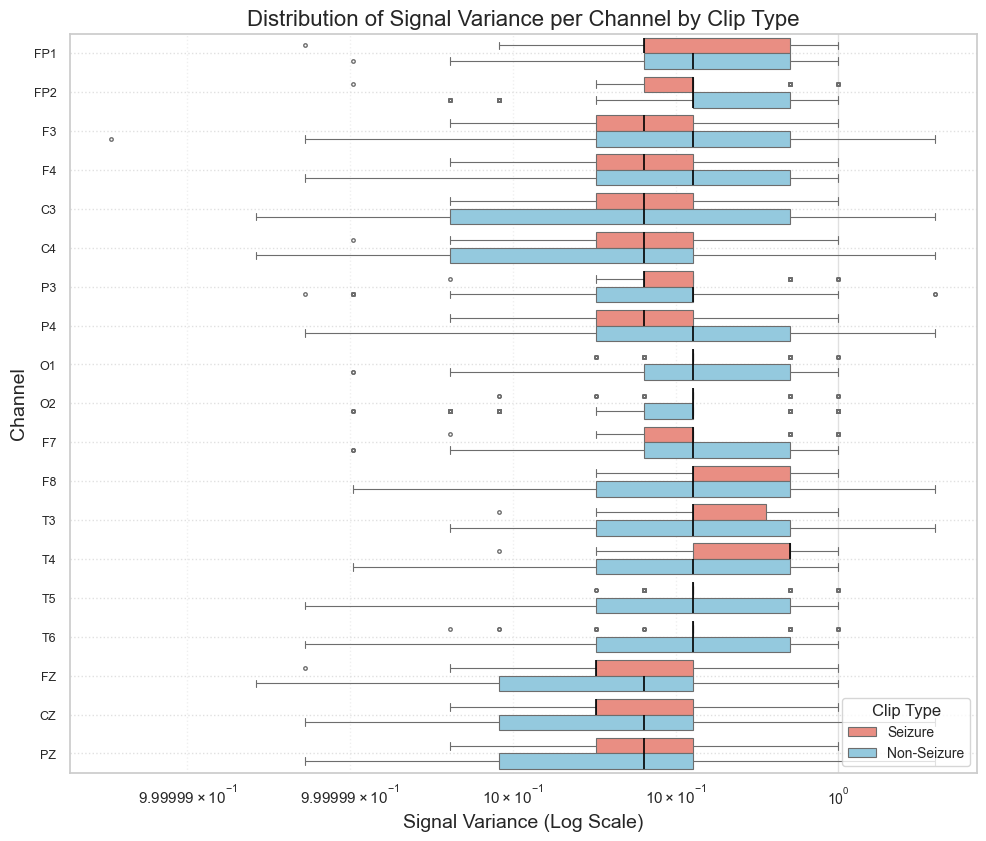

In [68]:
# --- Calculation of Channel Variances ---
channel_variances_data = []
limit = 1000
processed_count_var = 0 # Use a different counter to avoid confusion if run in same notebook

print(f"⏳ Calculating channel variances for up to {limit} clips...")
log_interval_var = max(1, limit // 10 if limit > 0 else 1)

for i in range(len(dataset_tr)):
    if processed_count_var >= limit:
        print(f"✔️ Reached calculation limit of {limit} clips for variance.")
        break
    
    try:
        data_obj = dataset_tr[i]
    except Exception as e:
        print(f"Warning: Error retrieving item {i} from dataset_tr: {e}. Skipping.")
        processed_count_var += 1
        continue

    signal_data_ch_time_tensor = data_obj.x
    label_tensor = data_obj.y

    if signal_data_ch_time_tensor is None:
        # print(f"Warning: Skipping item {i} for variance as signal_data (data_obj.x) is None.")
        processed_count_var += 1
        continue
        
    signal_data_ch_time = signal_data_ch_time_tensor.numpy()
    # signal_data_ch_time is (num_channels, num_timesteps)
    # np.var needs axis=1 to calculate variance across time for each channel
    
    if signal_data_ch_time.ndim != 2 or signal_data_ch_time.shape[1] == 0: # Need time points to calculate variance
        # print(f"Warning: Skipping item {i} for variance due to invalid signal data shape {signal_data_ch_time.shape}")
        processed_count_var += 1
        continue

    # Determine label
    current_label = None
    if label_tensor is not None:
        try:
            label_item = label_tensor.item()
            if pd.notna(label_item):
                current_label = int(label_item)
        except Exception:
            pass # Keep current_label as None
    
    if current_label is None: # Skip if no valid label
        processed_count_var += 1
        continue

    # Calculate variance along the time axis (axis=1) for each channel
    variances_per_channel = np.var(signal_data_ch_time, axis=1)
    
    num_channels_in_sample = signal_data_ch_time.shape[0] # Number of rows is num_channels

    for ch_idx, var_val in enumerate(variances_per_channel):
        ch_name = dataset_tr.channels[ch_idx] if ch_idx < len(dataset_tr.channels) else f'UnknownCh{ch_idx+1}'
        channel_variances_data.append({
            'variance': var_val,
            'label': current_label,
            'channel_index': ch_idx,
            'channel_name': ch_name
        })
    
    processed_count_var += 1
    if processed_count_var % log_interval_var == 0 or processed_count_var == limit or i == len(dataset_tr) -1:
        print(f"   Processed {processed_count_var}/{len(dataset_tr)} items for variance (limit: {limit})...")

print(f"✔️ Finished calculating variances for {processed_count_var} items.")

# --- Create DataFrame for Plotting ---
if not channel_variances_data:
    print("❌ No variance data was calculated. Skipping plot.")
else:
    variance_df = pd.DataFrame(channel_variances_data)
    variance_df['Clip Type'] = variance_df['label'].map({0: 'Non-Seizure', 1: 'Seizure'})

    # Ensure channel_name is categorical and ordered if dataset_tr.channels has a defined order
    if hasattr(dataset_tr, 'channels') and dataset_tr.channels:
        # Filter out any channel names in variance_df not present in dataset_tr.channels (if any discrepancy)
        known_channels = [ch for ch in dataset_tr.channels if ch in variance_df['channel_name'].unique()]
        if len(known_channels) < variance_df['channel_name'].nunique():
            print(f"⚠️ Warning: Some channel names in variance_df are not in dataset_tr.channels. Plotting known channels in order.")
        if known_channels: # Only proceed if there are known channels to order
            variance_df['channel_name'] = pd.Categorical(variance_df['channel_name'], categories=known_channels, ordered=True)
            variance_df.dropna(subset=['channel_name'], inplace=True) # Drop rows with channel names not in known_channels
            variance_df.sort_values('channel_name', inplace=True)


    # --- Plotting Channel Variance Box Plots ---
    if variance_df.empty:
        print("❌ Variance DataFrame is empty after filtering. Skipping plot.")
    else:
        print("📊 Plotting channel variance distributions...")
        
        num_unique_channels_plot = variance_df['channel_name'].nunique()
        fig_height = max(8, num_unique_channels_plot * 0.45) # Adjusted factor for better spacing
        plt.figure(figsize=(10, fig_height)) 

        sns.set_theme(style="whitegrid")
        sns.boxplot(
            data=variance_df,
            x='variance',
            y='channel_name',
            hue='Clip Type',
            orient='h',
            palette={'Non-Seizure': 'skyblue', 'Seizure': 'salmon'}, # Specific colors
            showfliers=True, 
            fliersize=2.5,      
            linewidth=0.8,    
            whiskerprops=dict(linewidth=0.8), 
            capprops=dict(linewidth=0.8),     
            medianprops=dict(color="black", linewidth=1.2) 
        )
        plt.title('Distribution of Signal Variance per Channel by Clip Type', fontsize=16)
        plt.xlabel('Signal Variance (Log Scale)', fontsize=14) 
        plt.ylabel('Channel', fontsize=14)
        
        if not variance_df['variance'].empty and variance_df['variance'].min() <= 1e-9: # Check for very small or zero variances
            print("⚠️ Warning: Very small or zero variance values found. Using 'symlog' scale for x-axis.")
            plt.xscale('symlog', linthresh=1e-5) # Use symlog if zeros/tiny values are present
            plt.xlabel('Signal Variance (Symlog Scale, linthresh=1e-5)', fontsize=14)
        elif not variance_df['variance'].empty:
             plt.xscale('log')
        else:
            print("Variance data is empty, cannot set x-scale.")


        plt.legend(title='Clip Type', loc='lower right', fontsize=10, title_fontsize=12) 
        
        plt.grid(True, which='major', axis='x', linestyle='-', alpha=0.6)
        plt.grid(True, which='minor', axis='x', linestyle=':', alpha=0.3) 
        plt.grid(True, axis='y', linestyle=':', alpha=0.6)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=9) # Adjust if channel names are long or many
        
        plt.tight_layout(pad=1.0)
        plt.show()

Observing the boxplots which display the distribution of signal variance for each channel, separated by class, a noticeable pattern occurs for certain channels. 

Specifically, for the non-seizure clips associated with channels $F3$, $F4$, $C3$, $C4$, $T3$, $FZ$, and $CZ$, the boxplots often show a wider spread extending towards lower variance values compared to the seizure clips. This is indicated by longer lower whiskers or the presence of outliers on the left side of the distribution (on the log scale). 

This suggests that non-seizure activity within these particular channels might include periods of lower signal variance than what is typically observed during seizure activity in this dataset.

### Seizure vs Non-Seizure Clips: Channel Correlation Matrix

Having previously identified channels that appear promising for distinguishing between seizure and non-seizure activity based on our analysis, this next step aims to confirm this hypothesis. We will now seek to validate which of the 19 channels are indeed the most meaningful discriminators between these two brain states.

⏳ Calculating correlation matrices for up to 1000 clips...
   Processed 100/12993 items for correlation (limit: 1000)...
   Processed 200/12993 items for correlation (limit: 1000)...
   Processed 300/12993 items for correlation (limit: 1000)...
   Processed 400/12993 items for correlation (limit: 1000)...
   Processed 500/12993 items for correlation (limit: 1000)...
   Processed 600/12993 items for correlation (limit: 1000)...
   Processed 700/12993 items for correlation (limit: 1000)...
   Processed 800/12993 items for correlation (limit: 1000)...
   Processed 900/12993 items for correlation (limit: 1000)...
   Processed 1000/12993 items for correlation (limit: 1000)...
✔️ Reached calculation limit of 1000 clips for correlation.
✔️ Finished calculating correlations. Iterated through 1000 items.
   Found 170 seizure clips with valid correlations.
   Found 830 non-seizure clips with valid correlations.


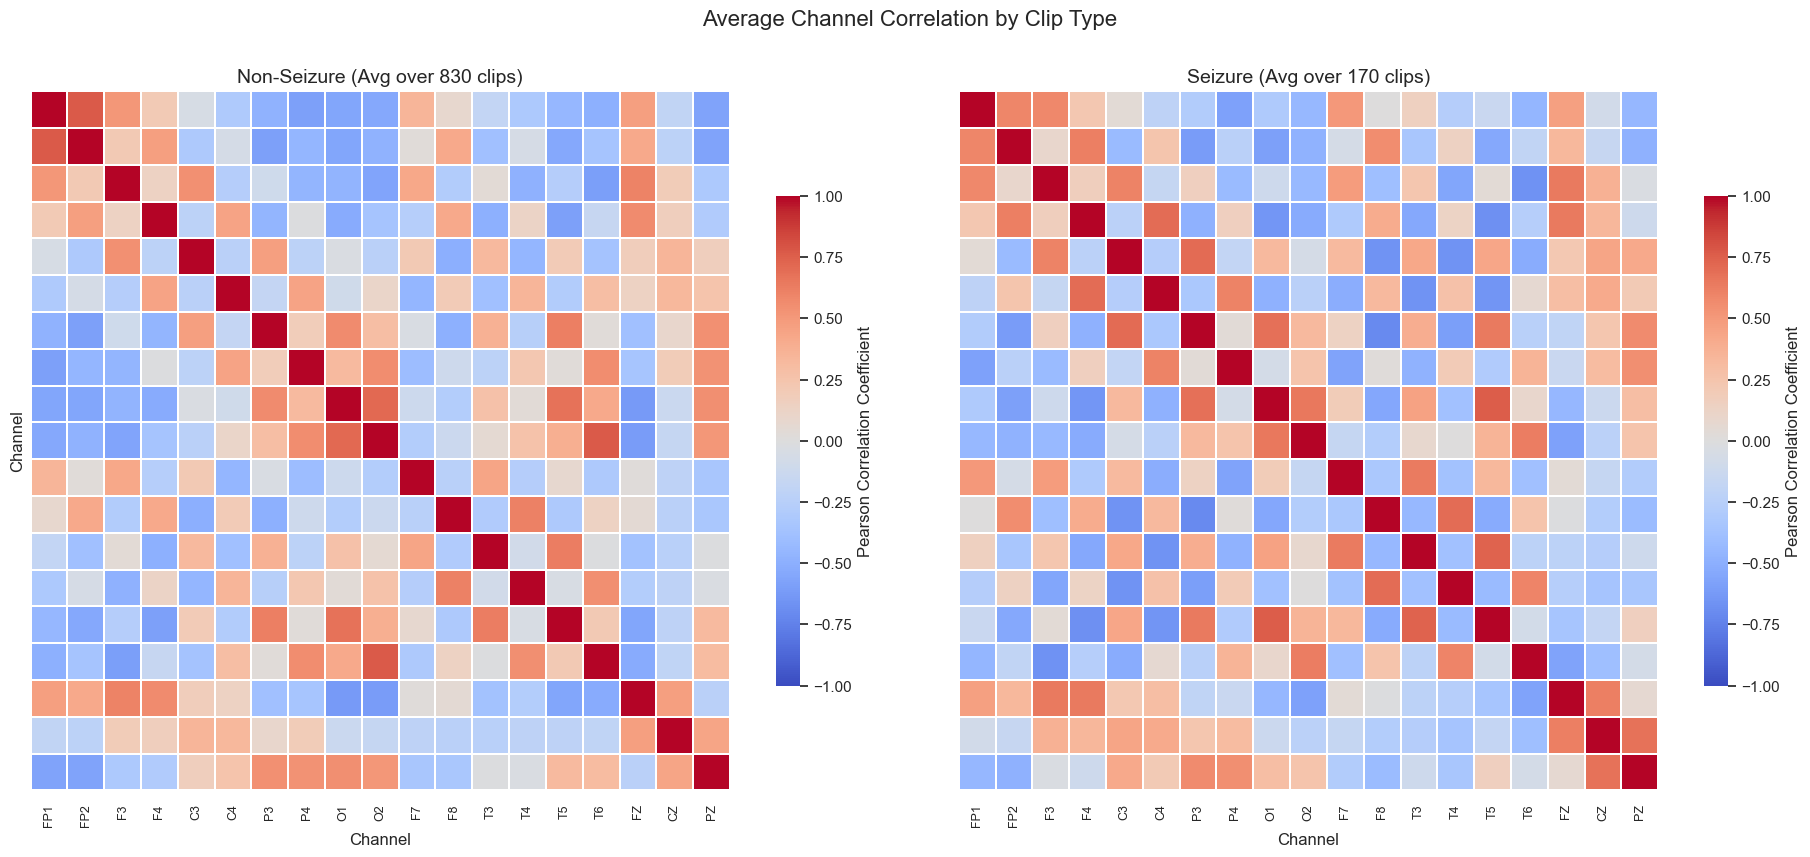

In [76]:
# --- Store correlation matrices for each class ---
corr_matrices_seizure = []
corr_matrices_non_seizure = []
limit = 1000 # Reduced for faster demo; user's original was 10e4 (100,000)

print(f"⏳ Calculating correlation matrices for up to {limit} clips...")
processed_count_corr = 0 # Use a different counter
log_interval_corr = max(1, limit // 10 if limit > 0 else 1)

for i in range(len(dataset_tr)): # Iterate using index
    if processed_count_corr >= limit:
        print(f"✔️ Reached calculation limit of {limit} clips for correlation.")
        break
    
    try:
        data_obj = dataset_tr[i]
    except Exception as e:
        print(f"Warning: Error retrieving item {i} from dataset_tr: {e}. Skipping.")
        processed_count_corr += 1
        continue

    signal_data_ch_time_tensor = data_obj.x # Shape: (num_channels, num_timesteps)
    label_tensor = data_obj.y

    if signal_data_ch_time_tensor is None:
        print(f"Warning: Skipping item {i} for correlation as signal_data (data_obj.x) is None.")
        processed_count_corr += 1
        continue
        
    signal_data_ch_time = signal_data_ch_time_tensor.numpy()
    
    # For pd.DataFrame(..., columns=channel_names), data should be (timesteps, channels)
    signal_data_time_ch = signal_data_ch_time.T # Transpose to (timesteps, channels)

    # Determine label
    current_label = None
    if label_tensor is not None:
        try:
            label_item = label_tensor.item()
            if pd.notna(label_item):
                current_label = int(label_item)
        except Exception:
            pass # Keep current_label as None
            
    if current_label is None: # Skip if no valid label for class-based correlation
        processed_count_corr += 1
        continue

    # Ensure signal_data_time_ch is a 2D numpy array with sufficient dimensions for correlation
    if signal_data_time_ch.ndim == 2 and signal_data_time_ch.shape[0] > 1 and signal_data_time_ch.shape[1] > 1:
        num_channels_in_sample = signal_data_time_ch.shape[1] # After transpose, axis 1 is channels
        
        # Use channel names corresponding to the actual number of channels in the sample
        # This assumes dataset_tr.channels contains the full list of potential channel names
        current_clip_channel_names = dataset_tr.channels[:num_channels_in_sample] if len(dataset_tr.channels) >= num_channels_in_sample else [f'Ch{j+1}' for j in range(num_channels_in_sample)]
        clip_df = pd.DataFrame(signal_data_time_ch, columns=current_clip_channel_names)
        
        try:
            corr_matrix = clip_df.corr()
            if not corr_matrix.isnull().values.any():
                if current_label == 1:
                    corr_matrices_seizure.append(corr_matrix.values)
                elif current_label == 0: # Explicitly check for 0
                    corr_matrices_non_seizure.append(corr_matrix.values)
            # else:
                # print(f"Warning: NaN found in correlation matrix for item {i}. Skipping.")
        except Exception: # Catch any error during .corr()
            # print(f"Warning: Could not compute correlation for item {i}. Error: {e}. Skipping.")
            pass
    # else:
        # print(f"Warning: Skipping item {i} for correlation due to unexpected data format or insufficient dimensions after extraction.")
    
    processed_count_corr += 1
    if processed_count_corr % log_interval_corr == 0 or processed_count_corr == limit or i == len(dataset_tr) -1 :
        print(f"   Processed {processed_count_corr}/{len(dataset_tr)} items for correlation (limit: {limit})...")

print(f"✔️ Finished calculating correlations. Iterated through {processed_count_corr} items.")
print(f"   Found {len(corr_matrices_seizure)} seizure clips with valid correlations.")
print(f"   Found {len(corr_matrices_non_seizure)} non-seizure clips with valid correlations.")

# --- Calculate the average correlation matrix for each class ---
avg_corr_seizure = None
avg_corr_non_seizure = None
num_channels_for_plot = 0 

if len(corr_matrices_seizure) > 0:
    avg_corr_seizure = np.mean(np.array(corr_matrices_seizure), axis=0)
    if avg_corr_seizure is not None: num_channels_for_plot = avg_corr_seizure.shape[0]
if len(corr_matrices_non_seizure) > 0:
    avg_corr_non_seizure = np.mean(np.array(corr_matrices_non_seizure), axis=0)
    if avg_corr_non_seizure is not None and num_channels_for_plot == 0: 
        num_channels_for_plot = avg_corr_non_seizure.shape[0]

# Determine effective channel names for plotting based on actual matrix size
effective_plot_channel_names = dataset_tr.channels[:num_channels_for_plot] if num_channels_for_plot > 0 and len(dataset_tr.channels) >= num_channels_for_plot else [f'Ch{j+1}' for j in range(num_channels_for_plot)]


# --- Plotting Average Correlation Heatmaps ---
sns.set_theme(style="whitegrid")
if avg_corr_non_seizure is not None or avg_corr_seizure is not None:
    fig, axes = plt.subplots(1, 2, figsize=(19, 8.5), sharey=True) # Adjusted figsize
    fig.suptitle('Average Channel Correlation by Clip Type', fontsize=16, y=0.97) # Adjusted y

    vmin_plot, vmax_plot = -1.0, 1.0 
    
    valid_avg_corrs_list = []
    if avg_corr_non_seizure is not None and np.any(np.isfinite(avg_corr_non_seizure)):
        valid_avg_corrs_list.append(avg_corr_non_seizure)
    if avg_corr_seizure is not None and np.any(np.isfinite(avg_corr_seizure)):
        valid_avg_corrs_list.append(avg_corr_seizure)

    if valid_avg_corrs_list:
        all_finite_vals = np.concatenate([m[np.isfinite(m)].flatten() for m in valid_avg_corrs_list])
        if all_finite_vals.size > 0:
            current_vmin = np.min(all_finite_vals)
            current_vmax = np.max(all_finite_vals)
            if current_vmin < 0 and current_vmax > 0: 
                abs_max = max(abs(current_vmin), abs(current_vmax))
                vmin_plot = -abs_max
                vmax_plot = abs_max
            elif current_vmin >=0 and current_vmax > 0: # All positive, scale from 0 to max
                vmin_plot = 0
                vmax_plot = current_vmax
            elif current_vmax <=0 and current_vmin < 0: # All negative, scale from min to 0
                vmin_plot = current_vmin
                vmax_plot = 0
            # else, default -1,1 is fine if all are zero or single value

    common_heatmap_kwargs = dict(
        cmap='coolwarm',
        vmin=vmin_plot, vmax=vmax_plot,
        square=True,
        linewidths=.3, 
        cbar_kws={"shrink": .70, "label": "Pearson Correlation Coefficient"}, # Adjusted shrink
        annot=False 
    )

    plot_successful = False
    ax_idx = 0 # Use a single index for axes array

    # Plot Non-Seizure Heatmap
    if avg_corr_non_seizure is not None:
        sns.heatmap(
            avg_corr_non_seizure, ax=axes[ax_idx],
            xticklabels=effective_plot_channel_names,
            yticklabels=effective_plot_channel_names, 
            **common_heatmap_kwargs
        )
        axes[ax_idx].set_title(f'Non-Seizure (Avg over {len(corr_matrices_non_seizure)} clips)', fontsize=14)
        axes[ax_idx].set_xlabel('Channel', fontsize=12)
        axes[ax_idx].set_ylabel('Channel', fontsize=12)
        axes[ax_idx].tick_params(axis='x', rotation=90, labelsize=9) # Adjusted labelsize
        axes[ax_idx].tick_params(axis='y', rotation=0, labelsize=9)  # Adjusted labelsize
        plot_successful = True
    else:
        axes[ax_idx].set_title('Non-Seizure (No data)', fontsize=14)
        axes[ax_idx].text(0.5,0.5, "No data", ha='center', va='center', transform=axes[ax_idx].transAxes)
    ax_idx += 1

    # Plot Seizure Heatmap
    if avg_corr_seizure is not None:
        sns.heatmap(
            avg_corr_seizure, ax=axes[ax_idx],
            xticklabels=effective_plot_channel_names,
            yticklabels=False, 
            **common_heatmap_kwargs
        )
        axes[ax_idx].set_title(f'Seizure (Avg over {len(corr_matrices_seizure)} clips)', fontsize=14)
        axes[ax_idx].set_xlabel('Channel', fontsize=12)
        axes[ax_idx].tick_params(axis='x', rotation=90, labelsize=9) # Adjusted labelsize
        plot_successful = True
    else:
        axes[ax_idx].set_title('Seizure (No data)', fontsize=14)
        axes[ax_idx].text(0.5,0.5, "No data", ha='center', va='center', transform=axes[ax_idx].transAxes)
    
    if plot_successful:
        plt.tight_layout(rect=[0, 0.03, 1, 0.94]) # Adjust rect for suptitle and labels
        plt.show()
    else: 
        plt.close(fig) 
        print("Neither seizure nor non-seizure correlation data was available to plot.")
else:
    print("❌ No correlation data was successfully calculated to plot (both avg_corr matrices are None).")



To identify channel pairs whose correlation patterns differ significantly between seizure and non-seizure states, we can compute a **correlation difference matrix**. This matrix highlights the connections that change the most, potentially indicating relevance for distinguishing between the two classes.

The change in correlation, $c^{\text{change}}$, between any two channels $i$ and $j$ is calculated as the absolute difference between their average correlation coefficients in the seizure ($c_{ij}^{\text{seizure}}$) and non-seizure ($c_{ij}^{\text{non-seizure}}$) states:

$$
c_{ij}^{\text{change}} = |c_{ij}^{\text{seizure}} - c_{ij}^{\text{non-seizure}}|
$$

High values in this matrix correspond to channel pairs where the functional connectivity (as measured by linear correlation) undergoes the largest change between the two conditions.

✅ Calculating difference between average seizure and non-seizure correlation matrices.
📊 Plotting the difference correlation matrix...


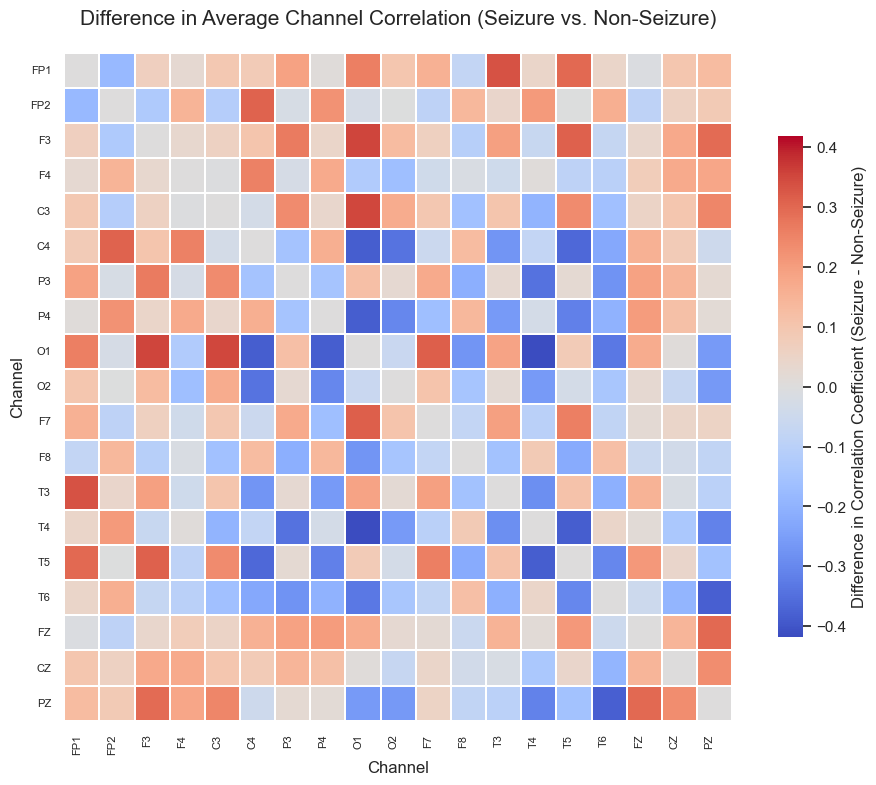

In [77]:
# --- Calculate the Difference Correlation Matrix ---
diff_corr_matrix = None
if avg_corr_seizure is not None and avg_corr_non_seizure is not None:
    if avg_corr_seizure.shape == avg_corr_non_seizure.shape:
        print("✅ Calculating difference between average seizure and non-seizure correlation matrices.")
        diff_corr_matrix = avg_corr_seizure - avg_corr_non_seizure
    else:
        print("❌ Error: Average correlation matrices (seizure and non-seizure) have different shapes. Cannot compute difference.")
        print(f"   Seizure shape: {avg_corr_seizure.shape}, Non-Seizure shape: {avg_corr_non_seizure.shape}")
elif avg_corr_seizure is None:
    print("❌ Error: Average seizure correlation matrix is not available. Cannot compute difference.")
elif avg_corr_non_seizure is None:
    print("❌ Error: Average non-seizure correlation matrix is not available. Cannot compute difference.")

# --- Plotting the Difference Correlation Heatmap ---
if diff_corr_matrix is not None and num_channels_for_plot > 0:
    print("📊 Plotting the difference correlation matrix...")
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 8)) # Adjust size as needed

    # Determine vmin and vmax for the difference matrix, centered at 0
    abs_max_diff = np.nanmax(np.abs(diff_corr_matrix)) # Max absolute difference
    vmin_diff = -abs_max_diff
    vmax_diff = abs_max_diff
    
    # If abs_max_diff is very close to zero, set a small default range to avoid issues with heatmap
    if np.isclose(abs_max_diff, 0):
        print("Warning: Maximum absolute difference is close to zero. Setting a default range for colormap.")
        vmin_diff, vmax_diff = -0.1, 0.1

    sns.heatmap(
        diff_corr_matrix,
        cmap='coolwarm', # Diverging colormap, good for differences around zero
        vmin=vmin_diff,
        vmax=vmax_diff,
        square=True,
        linewidths=.3,
        annot=False, # Annotations can be too dense; set to True or a matrix of strings for select values
        # annot_kws={"size": 7}, # if annot=True
        cbar_kws={"shrink": .75, "label": "Difference in Correlation Coefficient (Seizure - Non-Seizure)"},
        xticklabels=effective_plot_channel_names, # Use the channel names from previous step
        yticklabels=effective_plot_channel_names
    )

    plt.title('Difference in Average Channel Correlation (Seizure vs. Non-Seizure)', fontsize=15, y=1.03)
    plt.xlabel('Channel', fontsize=12)
    plt.ylabel('Channel', fontsize=12)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    if diff_corr_matrix is None:
        print("❌ No difference correlation matrix was calculated to plot.")
    elif num_channels_for_plot == 0:
        print("❌ Number of channels for plotting is zero. Cannot create heatmap.")


The absolute difference correlation matrix helps identify **pairs of channels** whose functional connectivity (measured by linear correlation) significantly changes between seizure and non-seizure states. By selecting the top $K$ pairs with the highest absolute difference values, we are essentially performing a feature selection strategy that prioritizes these **most altered pairwise interactions**.

In order to compute the **importance score** for individual channels based on this pairwise information, we use the sum of absolute differences across all other channels it is paired with. This score, $S_i$, for a channel $i$ reflects its total involvement in correlation changes:

$$
S_i = \sum_{j \neq i} |c_{ij}^{\text{seizure}} - c_{ij}^{\text{non-seizure}}| = \sum_{j \neq i} |c_{ij}^{\text{change}}|
$$

The top $K$ individual channels are then selected based on descending order of this score.

### Channel selection: identifying most important channels

In [78]:
from typing import Optional

def get_top_k_sensors_from_diff_corr(
    diff_corr_matrix: np.ndarray,
    channel_names: list[str],
    k: int,
    abs_values: bool = True
) -> Optional[list[tuple[str, float]]]:
    """
    Identifies the top K sensors that exhibit the largest changes in correlation
    based on the difference correlation matrix (seizure_avg_corr - non_seizure_avg_corr).

    The "score" for each sensor is the sum of the absolute values of its row/column
    in the difference correlation matrix (excluding the diagonal).

    Args:
        diff_corr_matrix (np.ndarray): The difference correlation matrix.
                                       Expected to be square.
        channel_names (List[str]): A list of channel names corresponding to the
                                   rows/columns of the diff_corr_matrix.
        k (int): The number of top sensors to return.
        abs_values (bool): If True (default), sums absolute differences. 
                           If False, sums raw differences (can be used to find sensors
                           that consistently increase or decrease correlations).

    Returns:
        Optional[List[Tuple[str, float]]]: A list of tuples, where each tuple
                                           contains (channel_name, score),
                                           sorted by score in descending order.
                                           Returns None if inputs are invalid.
    """
    # --- Input Validation ---
    if not isinstance(diff_corr_matrix, np.ndarray) or diff_corr_matrix.ndim != 2:
        print("Error: diff_corr_matrix must be a 2D NumPy array.")
        return None
    if diff_corr_matrix.shape[0] != diff_corr_matrix.shape[1]:
        print("Error: diff_corr_matrix must be a square matrix.")
        return None
    if not isinstance(channel_names, list) or len(channel_names) != diff_corr_matrix.shape[0]:
        print(f"Error: channel_names must be a list of strings with length "
              f"matching the dimensions of diff_corr_matrix ({diff_corr_matrix.shape[0]}).")
        return None
    if not isinstance(k, int) or k <= 0:
        print("Error: k must be a positive integer.")
        return None

    num_channels = diff_corr_matrix.shape[0]
    if k > num_channels:
        print(f"Warning: k ({k}) is greater than the number of available channels ({num_channels}). "
              f"Returning all channels sorted by score.")
        k = num_channels

    # --- Calculate Sensor Scores ---
    # Create a copy to avoid modifying the original matrix
    matrix_for_scoring = diff_corr_matrix.copy()
    
    # Set diagonal to 0 to exclude self-correlation changes (should be 0 anyway if original diagonals were 1)
    np.fill_diagonal(matrix_for_scoring, 0)

    if abs_values:
        # Sum of absolute changes in correlation for each sensor
        sensor_scores = np.sum(np.abs(matrix_for_scoring), axis=1) # Sum across rows
    else:
        # Sum of raw changes (positive changes increase score, negative changes decrease it)
        sensor_scores = np.sum(matrix_for_scoring, axis=1)


    # --- Pair scores with channel names ---
    scored_channels = []
    for i in range(num_channels):
        scored_channels.append((channel_names[i], sensor_scores[i]))

    # --- Sort channels by score in descending order ---
    # If abs_values is False, you might want to sort by absolute score for "top k"
    # or handle positive/negative scores separately depending on the goal.
    # Here, we sort by the score itself.
    if abs_values:
        scored_channels.sort(key=lambda item: item[1], reverse=True)
    else: # If summing raw differences, perhaps sort by absolute magnitude of the sum
        scored_channels.sort(key=lambda item: abs(item[1]), reverse=True)

    # --- Return top K sensors ---
    return scored_channels[:k]

In [79]:
k = 5
top_k_changing_sensors = get_top_k_sensors_from_diff_corr(
    diff_corr_matrix,
    effective_plot_channel_names,
    k
)

if top_k_changing_sensors:
    print(f"\nTop {k} sensors with the largest overall change in correlations:")
    for rank, (name, score) in enumerate(top_k_changing_sensors):
        print(f"  {rank+1}. {name} (Total Change Score: {score:.4f})")


Top 5 sensors with the largest overall change in correlations:
  1. O1 (Total Change Score: 4.1053)
  2. T5 (Total Change Score: 3.4402)
  3. C4 (Total Change Score: 3.2339)
  4. PZ (Total Change Score: 3.1663)
  5. T6 (Total Change Score: 3.0972)


## Data splitting and (possible) feature selection

In [80]:
from torch.utils.data import random_split

# ——— split training set into train & validation with pandas ———
print("⏳ Splitting into train/validation…")
split_start = time.time()
train_frac = 0.8
train_df   = clips_tr.sample(frac=train_frac)
val_df     = clips_tr.drop(train_df.index)
print(f"✔️ Split: {len(train_df)} train, {len(val_df)} val "
      f"(took {time.time()-split_start:.1f}s)")

# ——— rebuild training/validation datasets using the new split ———
print("⏳ Splitting dataset object into train/validation subsets…")
train_frac = 0.8
num_train_samples = int(len(dataset_tr) * train_frac)
num_val_samples = len(dataset_tr) - num_train_samples

dataset_tr, dataset_val = random_split(
    dataset_tr, [num_train_samples, num_val_samples]
)
print(f"✔️ Split complete: {len(dataset_tr)} train, {len(dataset_val)} val")

⏳ Splitting into train/validation…
✔️ Split: 10394 train, 2599 val (took 0.1s)
⏳ Splitting dataset object into train/validation subsets…
✔️ Split complete: 10394 train, 2599 val


In [81]:
# ——— create data loaders ———
print("⏳ Creating DataLoaders…")
dl_start = time.time()
common_loader_kwargs = dict(
    batch_size=128,
    num_workers=16,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=8,
)

# NOTE: shuffle=True for training, False for validation and test in order to
#       maintain the order of the data (important for evaluation)
train_loader = DataLoader(dataset_tr, shuffle=True,  **common_loader_kwargs)
val_loader   = DataLoader(dataset_val, shuffle=False, **common_loader_kwargs)
test_loader  = DataLoader(dataset_te, shuffle=False, **common_loader_kwargs)
print(f"✔️ DataLoaders created (took {time.time()-dl_start:.1f}s):\n"
      f"   • train: {len(train_loader)} batches\n"
      f"   • val:   {len(val_loader)} batches\n"
      f"   • test:  {len(test_loader)} batches")

⏳ Creating DataLoaders…
✔️ DataLoaders created (took 0.0s):
   • train: 82 batches
   • val:   21 batches
   • test:  29 batches


/Users/lucadibello/Developer/NeuroGraphNet/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Traditional approaches (no additional features)

In [82]:
%aimport src.utils.train
from src.utils.train import train_model, evaluate_model

### 1. LSTM classifier (baseline)

In [83]:
%aimport src.layers.lstm
import itertools
from src.layers.lstm import LSTM

LSTM_SAVE_PATH = CHECKPOINT_ROOT / "lstm_best_model.pt"
LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "lstm_submission.csv"

# define parameter grid
param_grid = {
    'hidden_dim': [32, 64, 128],
    'num_layers': [2, 3],
    'dropout': [0.2, 0.3, 0.4],
    'lr': [1e-4, 1e-3, 5e-3],
    'scheduler_patience': [3, 5], # Example: also tuning scheduler params
    'scheduler_factor': [0.1, 0.5]  # Example: also tuning scheduler params
}

# grid search loop
results = []
best_val_metric = float('inf')
num_epochs_per_combination = 10  # Number of epochs to train for each parameter set
best_params = {}

# Generate all combinations of parameters
keys, values = zip(*param_grid.items())
parameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Starting Grid Search with {len(parameter_combinations)} combinations...")
overall_start_time = time.time()
for i, params in enumerate(parameter_combinations):
    combination_start_time = time.time()
    print(f"\n--- Combination {i+1}/{len(parameter_combinations)} ---")
    print(f"Parameters: {params}")

    # Instantiate Model, Optimizer, and Scheduler with current parameters
    current_hidden_dim = params['hidden_dim']
    current_num_layers = params['num_layers']
    current_dropout = params['dropout']
    current_lr = params['lr']
    current_scheduler_patience = params['scheduler_patience']
    current_scheduler_factor = params['scheduler_factor']

    # build model with current parameters
    model = LSTM(input_dim=19,
                 hidden_dim=current_hidden_dim,
                 num_layers=current_num_layers,
                 dropout=current_dropout)

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for this combination.")
        model = nn.DataParallel(model)
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()  # Assuming this remains constant
    optimizer = optim.Adam(model.parameters(), lr=current_lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                     mode='min',
                                                     patience=current_scheduler_patience,
                                                     factor=current_scheduler_factor,
                                                     verbose=True)

    print(f"Training for {num_epochs_per_combination} epochs...")
    current_best_epoch_metric = float('inf') # For this combination

    # train model on training set (or load existing)
    train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=LSTM_SAVE_PATH,
        num_epochs=num_epochs_per_combination,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
    )

    # save best run among all the epochs
    current_best_epoch_metric = min(current_best_epoch_metric, np.min(train_losses))

    # Store results for this combination
    results.append({
        'params': params,
        'val_metric': current_best_epoch_metric,
        'training_time_seconds': time.time() - combination_start_time
    })
    print(f"Finished combination {i+1}. Best Val Metric for this run: {current_best_epoch_metric:.4f}")
    print(f"Time taken for this combination: {results[-1]['training_time_seconds']:.2f}s")

    # Update overall best parameters
    if current_best_epoch_metric < best_val_metric:
        best_val_metric = current_best_epoch_metric
        best_params = params
        print(f"✨ New best parameters found: {params} with validation metric: {best_val_metric:.4f}")

# print finished
overall_duration = time.time() - overall_start_time
print("\n--- Grid Search Complete ---")
print(f"Total time taken for grid search: {overall_duration:.2f}s")
if best_params:
    print(f"Best parameters found: {best_params}")
    print(f"Best validation metric (Loss): {best_val_metric:.4f}")
else:
    print("Grid search did not find any parameters (check your loops and data).")

/Users/lucadibello/Developer/NeuroGraphNet/.venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting Grid Search with 216 combinations...

--- Combination 1/216 ---
Parameters: {'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0001, 'scheduler_patience': 3, 'scheduler_factor': 0.1}
Training for 10 epochs...
Overwrite enabled: Removed existing checkpoint at .checkpoints/lstm_best_model.pt


Epochs:   0%|                                                                                    | 0/10 [00:07<?, ?it/s]
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=90, pipe_handle=128)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/lucadibello/Developer/NeuroGraphNet/src/utils/dataset.py", line 14, in <module>
    from torch_geometric.data import Dataset, Data
  File "/Users/lucadibello/Developer/NeuroGraphNet/.venv/lib/python3.13/site-p

KeyboardInterrupt: 

In [84]:
%aimport src.layers.lstm
from src.layers.lstm import LSTM

LSTM_SAVE_PATH = CHECKPOINT_ROOT / "lstm_best_model.pt"
LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "lstm_submission.csv"

# build model with current parameters
lstm_model = LSTM(input_dim=19,
                hidden_dim=current_hidden_dim,
                num_layers=current_num_layers,
                dropout=current_dropout)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for this combination.")
    lstm_model = nn.DataParallel(lstm_model)
lstm_model = lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Assuming this remains constant
optimizer = optim.Adam(lstm_model.parameters(), lr=current_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    mode='min',
                                                    patience=current_scheduler_patience,
                                                    factor=current_scheduler_factor,
                                                    verbose=True)


/Users/lucadibello/Developer/NeuroGraphNet/.venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
LSTM_SAVE_PATH = CHECKPOINT_ROOT / "lstm_best_model.pt"
LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=LSTM_SAVE_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

Epochs:   0%|                                                                                   | 0/300 [00:00<?, ?it/s]/Users/lucadibello/Developer/NeuroGraphNet/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    lstm_model, test_loader, device,
    save_path=LSTM_SAVE_PATH,
    submission_path=LSTM_SUBMISSION_PATH,
)

### 2. Bidirectional LSTM with early stopping

In [ ]:
from layers.lstm import BiLSTM

# Create model and fit it
bi_lstm_model = BiLSTM(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.2)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    bi_lstm_model = nn.DataParallel(bi_lstm_model)   # splits batches across all GPUs
bi_lstm_model = bi_lstm_model.to(device)         # CPU or GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(bi_lstm_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

In [ ]:
BI_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "bi_lstm_best_model.pt"
BI_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "bi_lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        bi_lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=BI_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    bi_lstm_model, test_loader, device,
    save_path=BI_LSTM_SAVE_PATH,
    submission_path=BI_LSTM_SUBMISSION_PATH,
)

### 3. LSTM with Attention and early stopping

In [ ]:
from layers.lstm import LSTMAttention

# Create model and fit it
attention_lstm_model = LSTMAttention(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.2)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    attention_lstm_model = nn.DataParallel(attention_lstm_model)   # splits batches across all GPUs
attention_lstm_model = attention_lstm_model.to(device)         # CPU or GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
    attention_lstm_model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min',
    patience=5,
    factor=0.5
)

In [ ]:
ATTENTION_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "attention_lstm_best_model.pt"
ATTENTION_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "attention_lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        attention_lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=ATTENTION_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=False,
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    attention_lstm_model, test_loader, device,
    save_path=ATTENTION_LSTM_SAVE_PATH,
    submission_path=ATTENTION_LSTM_SUBMISSION_PATH,
)

### 4. EEG CNN

In [ ]:
%aimport layers.cnn
from layers.cnn import EEG_CNN

eeg_cnn_model = EEG_CNN(
    input_channels=19,
    num_classes=1,
    dropout_rate=0.3
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    eeg_cnn_model = nn.DataParallel(eeg_cnn_model)
eeg_cnn_model = eeg_cnn_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(eeg_cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

In [ ]:
EEG_CNN_SAVE_PATH = CHECKPOINT_ROOT / "eeg_cnn_best_model.pt"
EEG_CNN_SUBMISSION_PATH = SUBMISSION_ROOT / "eeg_cnn_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        eeg_cnn_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=EEG_CNN_SUBMISSION_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    eeg_cnn_model, test_loader, device,
    save_path=EEG_CNN_SAVE_PATH,
    submission_path=EEG_CNN_SUBMISSION_PATH
)

### 5. CNN LSTM

In [ ]:
%aimport layers.cnn
from layers.cnn import CNN_LSTM

cnn_lstm_model = CNN_LSTM(
    input_channels=19,
    cnn_output_channels=128,
    lstm_hidden_dim=128, 
    fc_dropout=0.3,
    lstm_dropout=0.3,
    num_classes=1,
    bidirectional_lstm=False # unidirectional
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cnn_lstm_model = nn.DataParallel(cnn_lstm_model)
cnn_lstm_model = cnn_lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

In [ ]:
CNN_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "cnn_lstm_best_model.pt"
CNN_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "cnn_lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        cnn_lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=CNN_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    cnn_lstm_model, test_loader, device,
    save_path=CNN_LSTM_SAVE_PATH,
    submission_path=CNN_LSTM_SUBMISSION_PATH
)

### 6. CNN BiLSTM

In [ ]:
%aimport layers.cnn
from layers.cnn import CNN_LSTM

cnn_bi_lstm_model = CNN_LSTM(
    input_channels=19,
    cnn_output_channels=128,
    lstm_hidden_dim=128, 
    fc_dropout=0.3,
    lstm_dropout=0.3,
    num_classes=1,
    bidirectional_lstm=True
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cnn_bi_lstm_model = nn.DataParallel(cnn_bi_lstm_model)
cnn_bi_lstm_model = cnn_bi_lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_bi_lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

In [ ]:
CNN_BI_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "cnn_bi_lstm_best_model.pt"
CNN_BI_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "cnn_bi_lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
    cnn_bi_lstm_model, train_loader, val_loader,
    criterion, optimizer, device,
    save_path=CNN_BI_LSTM_SAVE_PATH,
    num_epochs=300,
    patience=30,
    monitor="val_loss",
    scheduler=scheduler,
    overwrite=True,
)

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    cnn_bi_lstm_model, test_loader, device,
    save_path=CNN_BI_LSTM_SAVE_PATH,
    submission_path=CNN_BI_LSTM_SUBMISSION_PATH
)

## Graph methods

In [ ]:
from src.utils.dataset import GraphEEGDataset

EDGE_STRATEGY = 'spatial' # or 'correlation'
SPATIAL_DISTANCE_FILE = DATA_ROOT / "distances_3d.csv"
CORRELATION_THRESHOLD = 0.7 # If using 'correlation'

# Train EEG Graph dataset
train_graph_dataset = GraphEEGDataset(
    root=str(TRAIN_ROOT),
    metadata_file=str(TRAIN_ROOT / "segments.parquet"),
    signal_folder=str(TRAIN_ROOT),
    edge_strategy=EDGE_STRATEGY,
    spatial_distance_file=str(SPATIAL_DISTANCE_FILE) if EDGE_STRATEGY == 'spatial' else None,
    correlation_threshold=CORRELATION_THRESHOLD if EDGE_STRATEGY == 'correlation' else 0.7,
    force_reprocess=False,
    # target entire signal length
    target_length=clip_length * sampling_rate,
    transform=fft_filtering,
)

In [ ]:
from pathlib import Path
from torch_geometric.data import Data

def train_gcn(
    model: torch.nn.Module,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device: torch.device,
    save_path: Path,
    scheduler=None,
    num_epochs: int = 100,
    patience: int = 10,
):
    """
    Simplified training loop for PyG models with checkpointing,
    LR scheduling, and early stopping based on validation loss.
    Supports loader yielding either PyG Data/Batch or tuples of tensors
    (x, edge_index, batch_idx, y).
    """
    best_val_loss = float('inf')
    early_stop_counter = 0
    train_hist, val_hist = [], []

    for epoch in range(1, num_epochs + 1):
        # --- Training Phase -------------------------------------------------
        model.train()
        train_loss = 0.0
        total_graphs = 0
        for batch in train_loader:
            # Handle different batch types
            if hasattr(batch, 'to'):
                # if PyG Batch, moves to device directly
                data = batch.to(device)
            else:
                print(len(batch))
                # Expect tuple (x, edge_index, batch_idx, y)
                x, edge_index, batch_idx, y = batch
                
                # load each tensor to device
                x = x.to(device)
                edge_index = edge_index.to(device)
                batch_idx = batch_idx.to(device)
                y = y.to(device)

                # merge everything into a Data object
                data = Data(x=x, edge_index=edge_index, batch=batch_idx, y=y)

            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            n = getattr(data, 'num_graphs', 1)
            train_loss += loss.item() * n
            total_graphs += n

        avg_train_loss = train_loss / total_graphs
        train_hist.append(avg_train_loss)

        # --- Validation Phase -----------------------------------------------
        model.eval()
        val_loss = 0.0
        total_graphs = 0
        with torch.no_grad():
            for batch in val_loader:
                if hasattr(batch, 'to'):
                    data = batch.to(device)
                else:
                    x, edge_index, batch_idx, y = batch
                    x = x.to(device)
                    edge_index = edge_index.to(device)
                    batch_idx = batch_idx.to(device)
                    y = y.to(device)
                    data = Data(x=x, edge_index=edge_index, batch=batch_idx, y=y)

                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)

                n = getattr(data, 'num_graphs', 1)
                val_loss += loss.item() * n
                total_graphs += n

        avg_val_loss = val_loss / total_graphs
        val_hist.append(avg_val_loss)

        # --- Scheduler ------------------------------------------------------
        if scheduler is not None:
            # if ReduceLROnPlateau, pass validation loss
            if hasattr(scheduler, 'step') and scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        # --- Logging --------------------------------------------------------
        print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # --- Early Stopping & Checkpointing --------------------------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            # Save state_dict of unwrapped model
            torch.save(getattr(model, 'module', model).state_dict(), save_path)
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # Load best model weights
    model.load_state_dict(torch.load(save_path, map_location=device))
    return train_hist, val_hist

In [ ]:
from layers.eeggcn import EEGGCN

# Get number of time points (in_channels) from first sample
cnn_lstm_model = EEGGCN(
    in_channels=19,
    hidden_channels=128,
    out_channels=32,
    num_classes=2,
    num_conv_layers=3,
    dropout=0.5
)
if torch.cuda.device_count() > 1:
    cnn_lstm_model = nn.DataParallel(cnn_lstm_model)
cnn_lstm_model = cnn_lstm_model.to(device)

# Set up optimizer + scheduler
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)
criterion = nn.BCEWithLogitsLoss()

EEGGCN_SAVE_PATH = CHECKPOINT_ROOT / "eeggcn_best_model.pt"
EEGCN_SUBMISSION_PATH = SUBMISSION_ROOT / "eeggcn_submission.csv"

# train model on training set (or load existing)
train_hist, val_hist = train_gcn(
    cnn_lstm_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    save_path   = Path("eegcnn_attn.pt"),
    scheduler   = scheduler,
    num_epochs  = 250,
    patience    = 15,
)

_ = evaluate_model(
    cnn_lstm_model, test_loader, device,
    save_path       = Path("eeggcn_attn.pt"),
    submission_path = Path("eeggcn_submission.csv"),
    threshold       = 0.5,
)